# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento da base**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extração de amostra dos dataframes
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Análise de cardinalidade
    - 3.3. Análise de variáveis não numéricas
    - 3.4. Selecionando variáveis não aplicáveis à modelagem
    - 3.5. Segmentação das bases **train** e **test**
    - 3.6. Transformação das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos
    - 4.2. Rankeamento dos modelo por score
    - 4.3. Análise gráfica de resíduos x previsões
    - 4.4. Tunagem dos hiperparâmetros do modelo com Optuna
        - 4.4.1. Tunagem do modelo **Bayesian Ridge**
        - 4.4.2. Tunagem do modelo **Linear Regression**
        - 4.4.3. Tunagem do modelo **Huber Regressor**
        - 4.4.4. Tunagem do modelo **Lasso**
        - 4.4.5. Tunagem do modelo **ElasticNet**

<br>

---

<br>

## 1. Importação de bibliotecas

In [204]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna
import joblib
import lightgbm as lgb
import catboost as cb

from category_encoders import TargetEncoder
from sklearn.metrics import (
    make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from optuna.samplers import TPESampler

from typing import Dict, Any, List, Tuple
from sklearn.base import BaseEstimator

In [205]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar opção para exibir todas as linhas do Dataframe
pd.set_option('display.max_rows', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos do Seaborn
sns.set_style('whitegrid')

## 2. Carregamento da base

In [206]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 18169


In [207]:
# Criando um dataframe a partir do arquivo *.csv

df = pd.read_csv('dados/Car_Purchasing_Data_Atualizado.csv', sep=';')
df.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount,debt_to_annual_salary,...,age_adjusted_income,wealth_growth_rate,financial_maturity_index,email_tld,age_range,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877,0.184827,...,9692.116370,0.090581,2.717416,edu,35 to 44,0,0,0,0,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566,0.143637,...,10408.495986,0.194316,5.829491,uk,35 to 44,0,0,1,1,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921,0.207447,...,8204.202132,0.275994,8.279818,uk,35 to 44,0,0,1,1,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313,0.181758,...,10421.796563,0.119171,3.575129,com,55 to 64,1,0,1,0,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248,0.089717,...,7911.319356,0.164575,4.937235,net,55 to 64,0,0,1,0,Moderate


## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [208]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata

In [209]:
generate_metadata(df)

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,Customer Name,object,0,0.0,498
1,Customer e-mail,object,0,0.0,500
2,Country,object,0,0.0,1
3,Gender,int64,0,0.0,2
4,Age,int64,0,0.0,43
5,Annual Salary,float64,0,0.0,500
6,Credit Card Debt,float64,0,0.0,500
7,Net Worth,float64,0,0.0,500
8,Car Purchase Amount,float64,0,0.0,500
9,debt_to_annual_salary,float64,0,0.0,500


### 3.2. Análise de cardinalidade

In [210]:
# Listando todas as variáveis com cardinalidade inferior a 2

cols_low_cardinality = [col for col in df.columns if df[col].nunique(dropna=False) < 2]
print(cols_low_cardinality)


['Country']


### 3.3. Análise de variáveis não numéricas

In [211]:
# Listando todas as variáveis object e category

cols_text = df.select_dtypes(include=[object, 'category']).columns.tolist()
print(cols_text)

['Customer Name', 'Customer e-mail', 'Country', 'email_tld', 'age_range', 'financial_status_category']


In [212]:
df[cols_text].head()

,Customer Name,Customer e-mail,Country,email_tld,age_range,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,edu,35 to 44,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,uk,35 to 44,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,uk,35 to 44,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,com,55 to 64,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,net,55 to 64,Moderate


In [213]:
# Detectar variáveis binárias (0 ou 1)
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()) <= {0, 1}
]
print(binary_cols)

# Transformando variáveis binárias (0 ou 1) em categóricas
df[binary_cols] = df[binary_cols].astype('category')

['Gender', 'high_income_flag', 'high_debt_flag', 'high_net_worth_flag', 'high_ppi_flag']


In [214]:
df[binary_cols].head()

,Gender,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag
0,0,0,0,0,0
1,0,0,0,1,1
2,1,0,0,1,1
3,1,1,0,1,0
4,1,0,0,1,0


### 3.4. Selecionando variáveis não aplicáveis à modelagem

In [215]:
# Separando as variáveis não aplicáveis à modelagem

vars_to_remove = ['Customer Name', 'Customer e-mail', 'Country']
if 'Age' in df.columns and 'age_range' in df.columns:
    vars_to_remove.append('Age')


### 3.5. Segmentação das bases **train** e **test**

In [216]:
# Separando as variáveis preditivas e a variável preditora (alvo)

target = 'Car Purchase Amount'
features = [col for col in df.columns if col not in [target] + vars_to_remove]


In [217]:
# Separação das features e o target
X = df[features]
y = df[target]

# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 3.6. Transformação das features das bases **train** e **test**

In [218]:
# Separando as variáveis numéricas e categóricas

numerical_features = X.select_dtypes(exclude=[object, 'category']).columns
categorical_features = X.select_dtypes(include=[object, 'category']).columns

In [219]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('variance', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [220]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [221]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (400, 26), y_train: (400,)
Shape: X_test:  (100, 26),  y_test: (100,)


In [222]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [223]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_processed.shape}')
print(f'Shape de X_test após transformação:  {X_test_processed.shape}')

Shape de X_train após transformação: (400, 43)
Shape de X_test após transformação:  (100, 43)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos

In [224]:
# Definindo os modelos a serem testados

models = {
    # Modelos lineares
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.001, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42),
    'BayesianRidge': BayesianRidge(),
    'HuberRegressor': HuberRegressor(),
    'SGDRegressor': SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    
    # Árvores e ensembles
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    
    # Boostings modernos
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='MAE', verbose=0),
}


In [225]:
def models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5):
    '''
    Avalia modelos de aprendizado de máquina, calculando métricas de desempenho 
    no conjunto de treino e teste.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada (K-Fold).

    :return: list
        Lista contendo os resultados de avaliação de cada modelo, RMSE e MAE para treino 
        e teste, além do tempo de execução.
    '''
    results = []
    
    # Inicializa o esquema de validação cruzada
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }
    
    # Loop pelos modelos a serem avaliados
    for model_name, model in models.items():
        # Cria um pipeline que combina o pré-processamento e o modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Registra o tempo de início
        start_time = time.time()
        
        # Executa validação cruzada no pipeline
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
        )
        
        # Calcula médias das métricas (convertendo para valores positivos)
        mean_cv_mae = -np.mean(cv_results['test_MAE'])
        mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
        mean_cv_r2 = np.mean(cv_results['test_R2'])
        
        # Ajusta o modelo final em todos os dados de treino
        pipeline.fit(X_train, y_train)
        
        # Gera previsões no conjunto de teste
        preds = pipeline.predict(X_test)
        
        # Métricas no teste
        test_rmse = np.sqrt(mean_squared_error(y_test, preds))
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)
        test_mape = mean_absolute_percentage_error(y_test, preds)
        
        # Calcula tempo total de execução
        elapsed = time.time() - start_time
        
        # Guarda resultados
        results.append({
            'Model': model_name,
            'CV_RMSE': mean_cv_rmse,
            'Test_RMSE': test_rmse,
            'CV_MAE': mean_cv_mae,
            'Test_MAE': test_mae,
            'CV_R2': mean_cv_r2,            
            'Test_R2': test_r2,
            'Test_MAPE': test_mape,
            'Time (s)': round(elapsed, 4)
        })
        
    return results

### 4.2. Rankeamento dos modelo por score

In [226]:
# Avaliando os modelos
results = models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
df_results = pd.DataFrame(results)

# Normaliza as métricas para ficarem na mesma escala
df_results['MAE_norm'] = (df_results['Test_MAE'] - df_results['Test_MAE'].min()) / (
    df_results['Test_MAE'].max() - df_results['Test_MAE'].min())
df_results['Time_norm'] = (df_results['Time (s)'] - df_results['Time (s)'].min()) / (
    df_results['Time (s)'].max() - df_results['Time (s)'].min())

# Fórmula de ranking: peso maior para erro (70%) e menor para tempo (30%)
df_results['Final_Score'] = (0.7 * df_results['MAE_norm']) + (0.3 * df_results['Time_norm'])

# Quanto menor o Final_Score, melhor o modelo
df_results.sort_values('Final_Score', ascending=True, inplace=True)

df_results

,Model,CV_RMSE,Test_RMSE,CV_MAE,Test_MAE,CV_R2,Test_R2,Test_MAPE,Time (s),MAE_norm,Time_norm,Final_Score
0,LinearRegression,1522.339668,798.013857,655.449819,561.578690,0.977103,0.994102,0.013558,0.0936,0.000000,0.019068,0.005720
4,BayesianRidge,1510.284208,804.532166,646.176425,588.939077,0.977485,0.994005,0.014266,0.0504,0.009088,0.000000,0.006361
5,HuberRegressor,1345.633036,972.229231,755.852265,738.217539,0.982472,0.991246,0.017323,0.1525,0.058671,0.045065,0.054589
3,ElasticNet,1320.455068,1028.711735,781.201419,803.274521,0.983348,0.990199,0.019710,0.0701,0.080280,0.008695,0.058804
2,Lasso,1495.249064,1020.355218,799.191065,777.159863,0.978823,0.990358,0.018972,0.1450,0.071606,0.041755,0.062650
1,Ridge,1357.624481,1104.561292,842.932178,879.050373,0.982898,0.988700,0.021990,0.0992,0.105449,0.021540,0.080276
6,SGDRegressor,1714.018615,1454.938476,1023.094973,1012.834625,0.971424,0.980395,0.025148,0.1307,0.149885,0.035443,0.115553
13,LightGBM,3287.519096,2493.866947,2182.508734,1710.724749,0.906201,0.942399,0.039207,0.3473,0.381691,0.131047,0.306498
12,XGBoost,3301.609033,2841.474763,2233.251279,2144.043129,0.905019,0.925222,0.049575,0.5667,0.525618,0.227887,0.436299
10,GradientBoosting,2896.366714,2781.580749,2069.174945,2140.683016,0.926945,0.928342,0.049026,0.5811,0.524502,0.234243,0.437424


### 4.3. Análise gráfica de resíduos x previsões

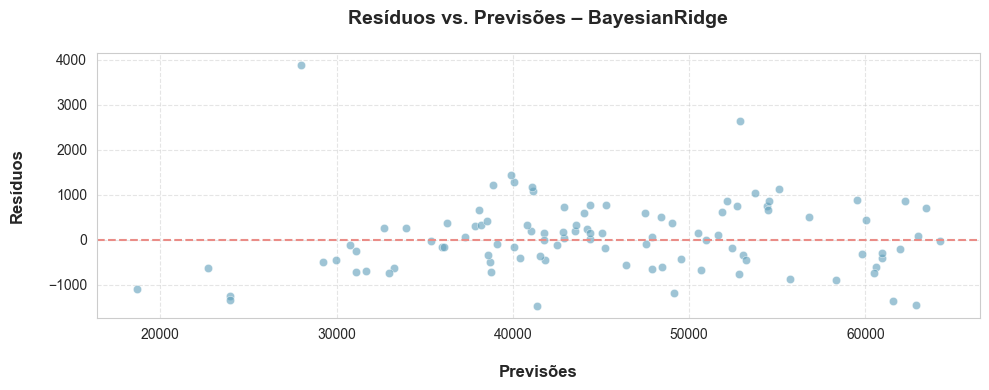

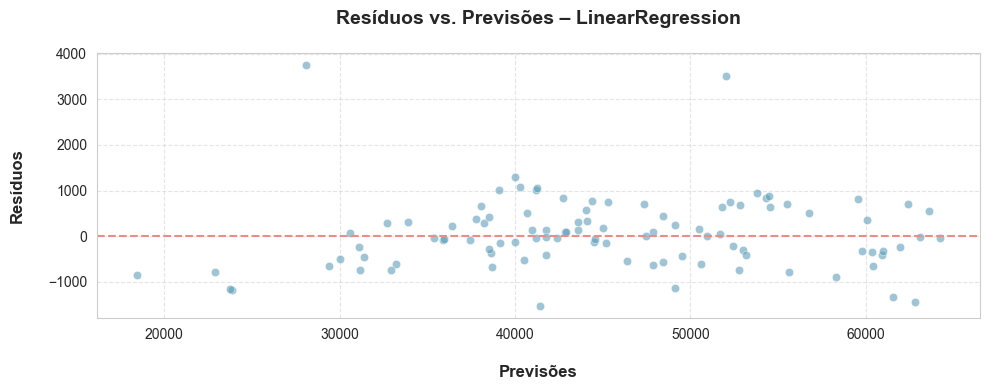

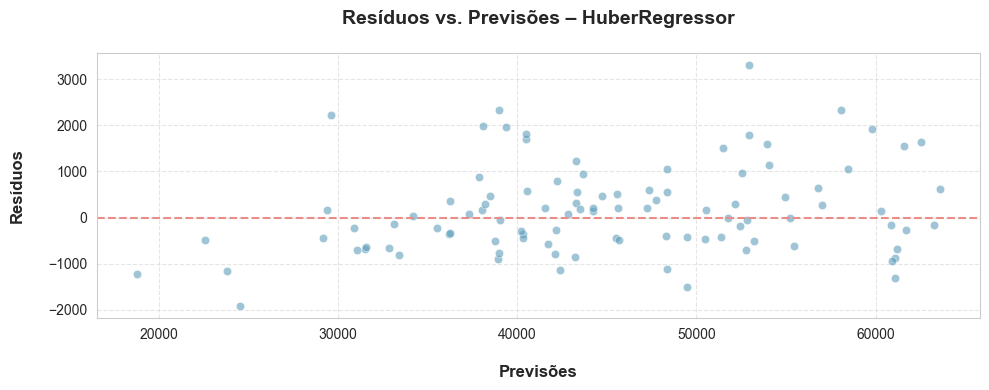

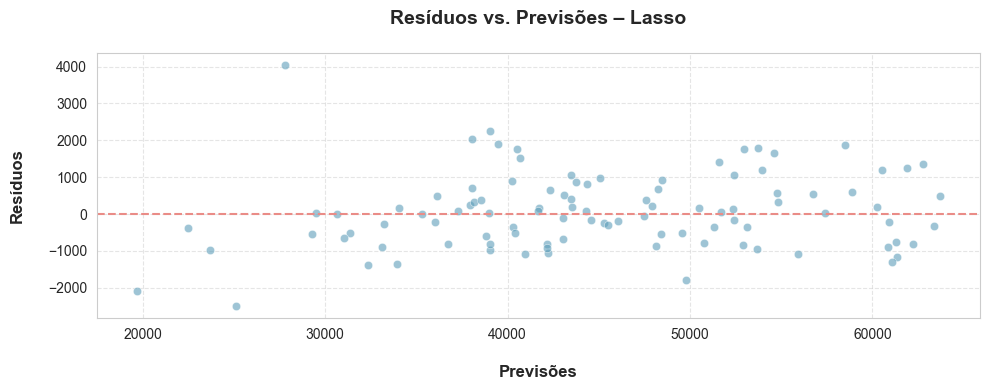

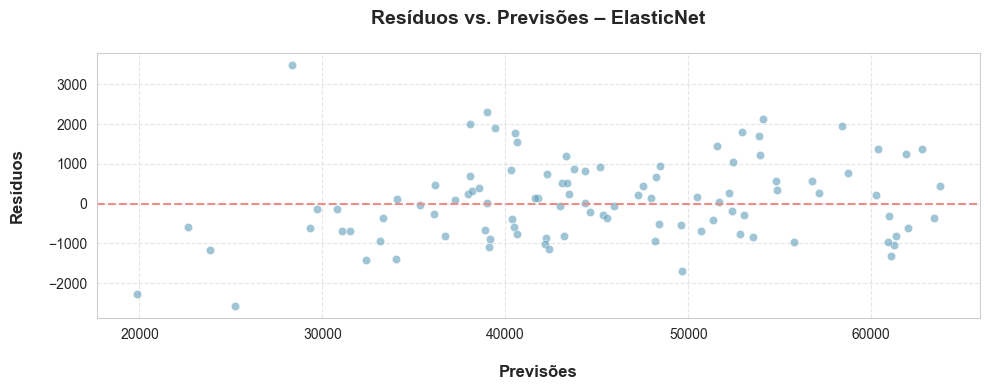

In [227]:
# Lista dos melhores modelos para análise
top_models = ['BayesianRidge', 'LinearRegression', 'HuberRegressor', 'Lasso', 'ElasticNet']

# Loop para ajustar cada modelo e gerar o gráfico de resíduos
for model_name in top_models:
    # Seleção do modelo atual
    model = models[model_name]
    
    # Criação do pipeline com pré-processamento e modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # Treinamento do pipeline com os dados de treino
    pipeline.fit(X_train, y_train)
    # Geração das previsões com os dados de teste
    preds = pipeline.predict(X_test)
    # Cálculo dos resíduos (diferença entre valor real e previsto)
    residuals = y_test - preds

    # Ajuste do tamanho da figura
    plt.figure(figsize=(10, 4))

    # Gráfico de dispersão dos resíduos em função das previsões
    sns.scatterplot(x=preds, y=residuals, color='#5d9eba', alpha=0.6)
    # Linha horizontal representando o ponto de resíduo zero
    plt.axhline(0, color='#ea8c87', linestyle='--', linewidth=1.5)
    # Título do gráfico com destaque
    plt.title(f'Resíduos vs. Previsões – {model_name}\n', 
              fontsize=14, fontweight='bold')
    # Rótulo do eixo X
    plt.xlabel('\nPrevisões', fontsize=12, fontweight='bold')
    # Rótulo do eixo Y
    plt.ylabel('Resíduos\n', fontsize=12, fontweight='bold')
    # Exibição da grade para melhor leitura dos dados
    plt.grid(True, linestyle='--', alpha=0.5)

    # Ajuste final do layout para evitar sobreposição
    plt.tight_layout()

    # Exibição do gráfico
    plt.show()


### 4.4. Tunagem dos hiperparâmetros do modelo com Optuna

#### 4.4.1. Tunagem do modelo **Bayesian Ridge**

In [228]:
def objective_bayesianridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo BayesianRidge usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = BayesianRidge(
        max_iter=trial.suggest_int('max_iter', 100, 500),
        tol=trial.suggest_float('tol', 1e-5, 1e-2, log=True),
        alpha_1=trial.suggest_float('alpha_1', 1e-8, 1e-3, log=True),
        alpha_2=trial.suggest_float('alpha_2', 1e-8, 1e-3, log=True),
        lambda_1=trial.suggest_float('lambda_1', 1e-8, 1e-3, log=True),
        lambda_2=trial.suggest_float('lambda_2', 1e-8, 1e-3, log=True),
        fit_intercept=True,
        compute_score=False,
        copy_X=True,
        verbose=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [229]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_bayesianridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-13 19:29:50,884] A new study created in memory with name: no-name-81ac220e-ceda-4e77-9606-52902c9f6348


[I 2025-11-13 19:29:51,005] Trial 0 finished with value: 646.1764245731314 and parameters: {'max_iter': 222, 'tol': 0.00014073861946573588, 'alpha_1': 6.774652239441945e-07, 'alpha_2': 8.591615185241847e-08, 'lambda_1': 1.0672593830224298e-08, 'lambda_2': 3.4396093834121924e-06}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:51,031] Trial 1 finished with value: 646.1764246699208 and parameters: {'max_iter': 424, 'tol': 0.0007097909565878979, 'alpha_1': 5.287037809947108e-07, 'alpha_2': 0.0005912720457108779, 'lambda_1': 1.5770484995777645e-07, 'lambda_2': 2.1488261481381285e-08}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:51,121] Trial 2 finished with value: 646.176424802866 and parameters: {'max_iter': 191, 'tol': 1.5110295123734615e-05, 'alpha_1': 4.928660067549385e-07, 'alpha_2': 1.2304490384482203e-07, 'lambda_1': 4.297427343637265e-07, 'lambda_2': 5.004518298704854e-06}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29

Best trial: 0. Best value: 646.176:  10%|█         | 10/100 [00:00<00:04, 20.67it/s, 0.47/1800 seconds]

[I 2025-11-13 19:29:51,166] Trial 6 finished with value: 646.1764397811594 and parameters: {'max_iter': 399, 'tol': 1.065574199677771e-05, 'alpha_1': 5.792135911695547e-07, 'alpha_2': 2.6166106837058802e-05, 'lambda_1': 2.888040811036859e-05, 'lambda_2': 0.00029973705569391975}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:51,183] Trial 4 finished with value: 646.1768614595527 and parameters: {'max_iter': 497, 'tol': 1.5677681799979303e-05, 'alpha_1': 0.0009447644257196827, 'alpha_2': 1.6960857253272905e-05, 'lambda_1': 0.0009236153466916464, 'lambda_2': 0.0005250662199080261}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:51,217] Trial 7 finished with value: 646.176424621658 and parameters: {'max_iter': 238, 'tol': 0.00027987786270394213, 'alpha_1': 3.938495643013909e-07, 'alpha_2': 3.6005876186761964e-05, 'lambda_1': 6.997110065709868e-08, 'lambda_2': 0.0001772099819968905}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:

Best trial: 0. Best value: 646.176:  15%|█▌        | 15/100 [00:00<00:03, 25.84it/s, 0.64/1800 seconds]

[I 2025-11-13 19:29:51,303] Trial 10 finished with value: 646.1766982677972 and parameters: {'max_iter': 439, 'tol': 0.007823007715766349, 'alpha_1': 6.02356474953026e-05, 'alpha_2': 2.1560552107350054e-08, 'lambda_1': 0.0005255284461533158, 'lambda_2': 1.5181478708993307e-07}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:51,343] Trial 11 finished with value: 646.1765672199738 and parameters: {'max_iter': 429, 'tol': 1.234972028872848e-05, 'alpha_1': 0.00021969282403955156, 'alpha_2': 1.6033877961267737e-06, 'lambda_1': 0.00029268806023595716, 'lambda_2': 7.683885801307312e-08}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:51,385] Trial 12 finished with value: 646.176424608247 and parameters: {'max_iter': 129, 'tol': 7.133845351384336e-05, 'alpha_1': 1.5464895764737155e-08, 'alpha_2': 1.3319714813778823e-06, 'lambda_1': 1.145308489240977e-08, 'lambda_2': 7.90343098929916e-07}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29

Best trial: 21. Best value: 646.176:  22%|██▏       | 22/100 [00:00<00:03, 25.37it/s, 0.92/1800 seconds]

[I 2025-11-13 19:29:51,496] Trial 14 finished with value: 646.1764246093793 and parameters: {'max_iter': 109, 'tol': 0.00010969306102126646, 'alpha_1': 1.1379634526204337e-08, 'alpha_2': 1.071125111151005e-06, 'lambda_1': 1.3387844309738982e-08, 'lambda_2': 2.3995418290285726e-06}. Best is trial 0 with value: 646.1764245731314.
[I 2025-11-13 19:29:51,599] Trial 17 finished with value: 646.1764250462577 and parameters: {'max_iter': 310, 'tol': 0.0007908244348987215, 'alpha_1': 5.568809249629982e-06, 'alpha_2': 1.0851642022026757e-07, 'lambda_1': 1.375591249244698e-06, 'lambda_2': 1.741869389582057e-05}. Best is trial 16 with value: 646.1764242471795.
[I 2025-11-13 19:29:51,629] Trial 18 finished with value: 646.1764249446227 and parameters: {'max_iter': 280, 'tol': 0.0009664504946091095, 'alpha_1': 4.096600289793895e-06, 'alpha_2': 1.1550326273240797e-07, 'lambda_1': 1.0361193330107478e-06, 'lambda_2': 1.9075660878861638e-05}. Best is trial 16 with value: 646.1764242471795.
[I 2025-11-1

Best trial: 25. Best value: 646.176:  27%|██▋       | 27/100 [00:01<00:02, 29.31it/s, 1.10/1800 seconds]

[I 2025-11-13 19:29:51,828] Trial 23 finished with value: 646.1764245491842 and parameters: {'max_iter': 218, 'tol': 3.272175874847495e-05, 'alpha_1': 1.5790231361914596e-06, 'alpha_2': 7.432020193626578e-06, 'lambda_1': 5.6251451707940344e-08, 'lambda_2': 7.077047910333103e-05}. Best is trial 21 with value: 646.1764239079082.
[I 2025-11-13 19:29:51,876] Trial 24 finished with value: 646.1764233897538 and parameters: {'max_iter': 371, 'tol': 3.144525252372144e-05, 'alpha_1': 2.376643189304931e-05, 'alpha_2': 4.217740946889697e-07, 'lambda_1': 6.392407419366258e-08, 'lambda_2': 2.8190207360834627e-07}. Best is trial 24 with value: 646.1764233897538.
[I 2025-11-13 19:29:51,909] Trial 25 finished with value: 646.1764233202905 and parameters: {'max_iter': 183, 'tol': 2.6794251790577034e-05, 'alpha_1': 2.5125321243026206e-05, 'alpha_2': 4.6259949701666183e-07, 'lambda_1': 6.736588766471711e-08, 'lambda_2': 2.6715762474254416e-07}. Best is trial 25 with value: 646.1764233202905.
[I 2025-11-1

Best trial: 33. Best value: 646.176:  33%|███▎      | 33/100 [00:01<00:02, 25.69it/s, 1.34/1800 seconds]

[I 2025-11-13 19:29:52,035] Trial 29 finished with value: 646.1764237631734 and parameters: {'max_iter': 378, 'tol': 3.428393610254763e-05, 'alpha_1': 1.8231952913768985e-05, 'alpha_2': 3.562528786888022e-07, 'lambda_1': 2.2190319282119766e-07, 'lambda_2': 2.396712978638908e-07}. Best is trial 25 with value: 646.1764233202905.
[I 2025-11-13 19:29:52,085] Trial 28 finished with value: 646.1764236895415 and parameters: {'max_iter': 370, 'tol': 3.1751418683326996e-05, 'alpha_1': 2.0859612351336993e-05, 'alpha_2': 4.84070459219101e-07, 'lambda_1': 3.437277233580276e-07, 'lambda_2': 2.8250753945266465e-07}. Best is trial 25 with value: 646.1764233202905.
[I 2025-11-13 19:29:52,108] Trial 30 finished with value: 646.176420125202 and parameters: {'max_iter': 166, 'tol': 2.5704923203785676e-05, 'alpha_1': 8.768316857787092e-05, 'alpha_2': 3.364475188095796e-07, 'lambda_1': 2.2943397504027756e-07, 'lambda_2': 2.809800806991676e-07}. Best is trial 30 with value: 646.176420125202.
[I 2025-11-13 1

Best trial: 37. Best value: 646.176:  38%|███▊      | 38/100 [00:01<00:02, 26.07it/s, 1.53/1800 seconds]

[I 2025-11-13 19:29:52,220] Trial 34 finished with value: 646.1764192080874 and parameters: {'max_iter': 161, 'tol': 2.0973507983851785e-05, 'alpha_1': 0.00010319829020051425, 'alpha_2': 6.360403664602309e-07, 'lambda_1': 3.2819090651223474e-08, 'lambda_2': 1.1327348093242968e-08}. Best is trial 33 with value: 646.1764189274144.
[I 2025-11-13 19:29:52,337] Trial 36 finished with value: 646.1764193036838 and parameters: {'max_iter': 150, 'tol': 2.0140379545409404e-05, 'alpha_1': 0.00012753037808766658, 'alpha_2': 3.2346424830452497e-06, 'lambda_1': 2.637141839181023e-06, 'lambda_2': 1.598169756736281e-06}. Best is trial 33 with value: 646.1764189274144.
[I 2025-11-13 19:29:52,339] Trial 35 finished with value: 646.1764210731366 and parameters: {'max_iter': 165, 'tol': 2.0012474773494066e-05, 'alpha_1': 0.0001341551776750078, 'alpha_2': 3.372592129289906e-06, 'lambda_1': 6.6567363617316605e-06, 'lambda_2': 1.4498500955245632e-08}. Best is trial 33 with value: 646.1764189274144.
[I 2025-1

Best trial: 45. Best value: 646.176:  46%|████▌     | 46/100 [00:01<00:02, 26.89it/s, 1.83/1800 seconds]

[I 2025-11-13 19:29:52,446] Trial 39 finished with value: 646.1764119419088 and parameters: {'max_iter': 146, 'tol': 1.0691457883498967e-05, 'alpha_1': 0.0003659097288816977, 'alpha_2': 0.0001932196977317866, 'lambda_1': 1.2394649633474151e-05, 'lambda_2': 1.4491469515038876e-06}. Best is trial 39 with value: 646.1764119419088.
[I 2025-11-13 19:29:52,501] Trial 40 finished with value: 646.176400452357 and parameters: {'max_iter': 139, 'tol': 1.0060052816669675e-05, 'alpha_1': 0.0004608658357560073, 'alpha_2': 9.735752649746147e-05, 'lambda_1': 3.26628670738659e-08, 'lambda_2': 1.6909942574238907e-06}. Best is trial 40 with value: 646.176400452357.
[I 2025-11-13 19:29:52,539] Trial 41 finished with value: 646.1764003901619 and parameters: {'max_iter': 146, 'tol': 0.0001154087266924436, 'alpha_1': 0.000462024926520666, 'alpha_2': 0.00013091248848712327, 'lambda_1': 2.839395718992281e-08, 'lambda_2': 1.6924673292354464e-06}. Best is trial 41 with value: 646.1764003901619.
[I 2025-11-13 19

[I 2025-11-13 19:29:52,805] Trial 46 finished with value: 646.1764004338218 and parameters: {'max_iter': 203, 'tol': 1.019190111847114e-05, 'alpha_1': 0.000985116106786642, 'alpha_2': 0.00034194327126056456, 'lambda_1': 5.21986541587061e-05, 'lambda_2': 4.519543100556272e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:52,810] Trial 49 finished with value: 646.1763990436623 and parameters: {'max_iter': 128, 'tol': 0.00047053666822657056, 'alpha_1': 0.0008842714172285261, 'alpha_2': 0.0002642058335353899, 'lambda_1': 3.95093271921003e-05, 'lambda_2': 4.13407178586701e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:52,861] Trial 51 finished with value: 646.1764018997366 and parameters: {'max_iter': 202, 'tol': 0.0004078193376855428, 'alpha_1': 0.0009965123750363054, 'alpha_2': 0.0009429193171392131, 'lambda_1': 5.6106760138101865e-05, 'lambda_2': 3.778790257064428e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:

Best trial: 45. Best value: 646.176:  56%|█████▌    | 56/100 [00:02<00:01, 25.72it/s, 2.26/1800 seconds]

[I 2025-11-13 19:29:52,902] Trial 48 finished with value: 646.1764107956266 and parameters: {'max_iter': 203, 'tol': 1.0234119301166641e-05, 'alpha_1': 0.0009403607315780747, 'alpha_2': 0.0003015512594255977, 'lambda_1': 6.741796537304882e-05, 'lambda_2': 3.2152813815236594e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,001] Trial 52 finished with value: 646.1764656835572 and parameters: {'max_iter': 234, 'tol': 0.00034842530544172456, 'alpha_1': 0.0005966774315175915, 'alpha_2': 6.716653288078513e-05, 'lambda_1': 0.00013741721013347212, 'lambda_2': 8.801236409784545e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,003] Trial 53 finished with value: 646.1764041403515 and parameters: {'max_iter': 127, 'tol': 0.0004812159927183253, 'alpha_1': 0.0006014489126414228, 'alpha_2': 7.926399703801873e-05, 'lambda_1': 2.102664980284954e-05, 'lambda_2': 9.539491534418953e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 1

Best trial: 45. Best value: 646.176:  61%|██████    | 61/100 [00:02<00:01, 24.48it/s, 2.50/1800 seconds]

[I 2025-11-13 19:29:53,174] Trial 56 finished with value: 646.176417269646 and parameters: {'max_iter': 125, 'tol': 0.0002434964159634821, 'alpha_1': 0.00022046993285007664, 'alpha_2': 0.0005476136202637805, 'lambda_1': 8.023535298232845e-06, 'lambda_2': 2.2437440831422655e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,211] Trial 57 finished with value: 646.176412763675 and parameters: {'max_iter': 263, 'tol': 0.00026006824975061544, 'alpha_1': 0.0003173530238478585, 'alpha_2': 0.000544899574038977, 'lambda_1': 9.114239361065326e-06, 'lambda_2': 2.335495899174308e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,243] Trial 59 finished with value: 646.176419194985 and parameters: {'max_iter': 121, 'tol': 0.00024713775079229804, 'alpha_1': 0.00019647492836944128, 'alpha_2': 0.000516207217803032, 'lambda_1': 9.290147952690388e-06, 'lambda_2': 2.4470522368245702e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:2

[I 2025-11-13 19:29:53,376] Trial 62 finished with value: 646.176437204272 and parameters: {'max_iter': 101, 'tol': 0.0014190132364340082, 'alpha_1': 4.1712689183846835e-05, 'alpha_2': 2.004807178556592e-05, 'lambda_1': 2.805051772409302e-05, 'lambda_2': 5.744234515812694e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,501] Trial 64 finished with value: 646.1764154554746 and parameters: {'max_iter': 181, 'tol': 0.0006159313653898861, 'alpha_1': 0.0003616092201561562, 'alpha_2': 0.00013837420469662779, 'lambda_1': 1.8630001675150666e-05, 'lambda_2': 1.147091874822464e-07}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,509] Trial 63 finished with value: 646.1764034174291 and parameters: {'max_iter': 136, 'tol': 4.989848532774242e-05, 'alpha_1': 0.0004280548439084168, 'alpha_2': 0.00013659816940202004, 'lambda_1': 2.3944233601860795e-06, 'lambda_2': 1.395208431378021e-07}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 1

[I 2025-11-13 19:29:53,620] Trial 65 finished with value: 646.1764034378868 and parameters: {'max_iter': 180, 'tol': 0.00016368686107475703, 'alpha_1': 0.0004258673172632832, 'alpha_2': 0.00015056993748660224, 'lambda_1': 2.215250591705741e-06, 'lambda_2': 1.0578932014532628e-07}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,639] Trial 69 finished with value: 646.1764324179296 and parameters: {'max_iter': 175, 'tol': 0.004656385262289545, 'alpha_1': 0.0007196117585413753, 'alpha_2': 4.5017203716494926e-05, 'lambda_1': 8.645127227200502e-05, 'lambda_2': 6.389049213594553e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,691] Trial 68 finished with value: 646.1764258725874 and parameters: {'max_iter': 136, 'tol': 0.00014471689987342233, 'alpha_1': 5.5765074798169245e-08, 'alpha_2': 0.00013271181479023976, 'lambda_1': 2.416163747499415e-06, 'lambda_2': 1.429217020134799e-07}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13

Best trial: 73. Best value: 646.176:  77%|███████▋  | 77/100 [00:03<00:00, 23.29it/s, 3.12/1800 seconds]

[I 2025-11-13 19:29:53,780] Trial 70 finished with value: 646.1764045609452 and parameters: {'max_iter': 114, 'tol': 1.564951170460825e-05, 'alpha_1': 0.0007422612499771386, 'alpha_2': 4.018580741612824e-05, 'lambda_1': 3.5853411074046016e-05, 'lambda_2': 6.535014833216174e-08}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,785] Trial 72 finished with value: 646.1763900116151 and parameters: {'max_iter': 114, 'tol': 1.3848492597030933e-05, 'alpha_1': 0.0007151290597078928, 'alpha_2': 4.3866787638627026e-05, 'lambda_1': 5.524561792843505e-06, 'lambda_2': 4.672343041693051e-07}. Best is trial 45 with value: 646.1763799206213.
[I 2025-11-13 19:29:53,851] Trial 73 finished with value: 646.1763782292312 and parameters: {'max_iter': 226, 'tol': 1.562595704155274e-05, 'alpha_1': 0.0009421161480875342, 'alpha_2': 0.00037858197427496725, 'lambda_1': 5.752980676189747e-06, 'lambda_2': 4.1143332257315043e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 

Best trial: 73. Best value: 646.176:  81%|████████  | 81/100 [00:03<00:00, 22.97it/s, 3.33/1800 seconds]

[I 2025-11-13 19:29:54,079] Trial 77 finished with value: 646.1764229708775 and parameters: {'max_iter': 118, 'tol': 1.2970265659715363e-05, 'alpha_1': 0.0001564247016655381, 'alpha_2': 0.0008658339457555208, 'lambda_1': 1.2477573068561405e-05, 'lambda_2': 1.6924782646043303e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,131] Trial 78 finished with value: 646.1764170053716 and parameters: {'max_iter': 220, 'tol': 1.2686951514559722e-05, 'alpha_1': 0.0002721845730884113, 'alpha_2': 0.0009949195496199695, 'lambda_1': 1.2676462237138136e-05, 'lambda_2': 1.6986274800010187e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,137] Trial 80 finished with value: 646.1764195402457 and parameters: {'max_iter': 213, 'tol': 1.3610471824641323e-05, 'alpha_1': 0.00015731104626358138, 'alpha_2': 0.00021009111535552974, 'lambda_1': 6.0516850242788686e-06, 'lambda_2': 1.485579185947281e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-1

Best trial: 73. Best value: 646.176:  86%|████████▌ | 86/100 [00:03<00:00, 22.92it/s, 3.49/1800 seconds]

[I 2025-11-13 19:29:54,245] Trial 82 finished with value: 646.1763949631909 and parameters: {'max_iter': 191, 'tol': 2.7170488814719458e-05, 'alpha_1': 0.0006163357268146283, 'alpha_2': 0.00020613959034481238, 'lambda_1': 5.089778741187045e-06, 'lambda_2': 3.2204709238211744e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,288] Trial 83 finished with value: 646.1763971823241 and parameters: {'max_iter': 214, 'tol': 2.5704757092884136e-05, 'alpha_1': 0.0005782415282556492, 'alpha_2': 0.00023432314670848543, 'lambda_1': 5.510470513432041e-06, 'lambda_2': 2.997910806381602e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,288] Trial 85 finished with value: 646.1763961045693 and parameters: {'max_iter': 192, 'tol': 1.6601536069057643e-05, 'alpha_1': 0.0005802756849680726, 'alpha_2': 0.0004173346944487744, 'lambda_1': 3.666346462496728e-06, 'lambda_2': 2.8759299941531753e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-1

Best trial: 73. Best value: 646.176:  92%|█████████▏| 92/100 [00:03<00:00, 27.82it/s, 3.72/1800 seconds]

[I 2025-11-13 19:29:54,441] Trial 88 finished with value: 646.1763972757307 and parameters: {'max_iter': 193, 'tol': 1.7982018472203898e-05, 'alpha_1': 0.0005535739988386287, 'alpha_2': 0.00010292641285736315, 'lambda_1': 3.2315501971117217e-06, 'lambda_2': 3.0694918211144216e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,467] Trial 87 finished with value: 646.1763983409097 and parameters: {'max_iter': 190, 'tol': 1.7596553010107134e-05, 'alpha_1': 0.0005346131280431969, 'alpha_2': 0.0003577768198509434, 'lambda_1': 3.3661381752723545e-06, 'lambda_2': 1.0289084284400655e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,507] Trial 89 finished with value: 646.1764001838649 and parameters: {'max_iter': 292, 'tol': 2.6218649445595933e-05, 'alpha_1': 0.0005002733570546832, 'alpha_2': 0.00037288312514563486, 'lambda_1': 3.4464066593443107e-06, 'lambda_2': 1.15398021817677e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11

Best trial: 73. Best value: 646.176:  99%|█████████▉| 99/100 [00:03<00:00, 23.69it/s, 3.98/1800 seconds]

[I 2025-11-13 19:29:54,700] Trial 93 finished with value: 646.1763849002641 and parameters: {'max_iter': 323, 'tol': 5.029861782486556e-05, 'alpha_1': 0.0007762060288096719, 'alpha_2': 9.78308056511587e-05, 'lambda_1': 1.8993128251254064e-06, 'lambda_2': 5.545651544378056e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,713] Trial 92 finished with value: 646.1763855628823 and parameters: {'max_iter': 321, 'tol': 5.2823192513961545e-05, 'alpha_1': 0.000757784393220104, 'alpha_2': 9.525088082868249e-05, 'lambda_1': 1.3232306946609475e-06, 'lambda_2': 4.9345275113384003e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19:29:54,733] Trial 96 finished with value: 646.1763872495183 and parameters: {'max_iter': 253, 'tol': 2.2227173150617416e-05, 'alpha_1': 0.0007290067467956093, 'alpha_2': 0.0007111332989037857, 'lambda_1': 1.661357120813775e-06, 'lambda_2': 3.007513802387799e-08}. Best is trial 73 with value: 646.1763782292312.
[I 2025-11-13 19

Best trial: 73. Best value: 646.176: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s, 4.01/1800 seconds]

[I 2025-11-13 19:29:54,889] Trial 99 finished with value: 646.1763819092652 and parameters: {'max_iter': 314, 'tol': 7.900776313872974e-05, 'alpha_1': 0.0008201924495133006, 'alpha_2': 6.133017465137596e-05, 'lambda_1': 5.994573065223384e-07, 'lambda_2': 7.795701119087112e-08}. Best is trial 73 with value: 646.1763782292312.


In [230]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_bayesianridge = study.best_value
params_bayesianridge = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'max_iter': 226, 'tol': 1.562595704155274e-05, 'alpha_1': 0.0009421161480875342, 'alpha_2': 0.00037858197427496725, 'lambda_1': 5.752980676189747e-06, 'lambda_2': 4.1143332257315043e-08}

Melhor MAE: 646.1764


#### 4.4.2. Tunagem do modelo **Linear Regression**

In [231]:
def objective_linearregression(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo LinearRegression usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = LinearRegression(
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        positive=trial.suggest_categorical('positive', [True, False]),
        n_jobs=None
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [232]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_linearregression, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-13 19:29:54,921] A new study created in memory with name: no-name-d6af7e33-6956-4859-9c3d-983361e71a81
Best trial: 0. Best value: 1898.54:   1%|          | 1/100 [00:00<00:13,  7.59it/s, 0.13/1800 seconds]

[I 2025-11-13 19:29:55,039] Trial 0 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 1898.5433640047165.


Best trial: 4. Best value: 655.45:   4%|▍         | 4/100 [00:00<00:06, 13.85it/s, 0.25/1800 seconds] 

[I 2025-11-13 19:29:55,075] Trial 1 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 1 with value: 655.4498191947844.
[I 2025-11-13 19:29:55,089] Trial 2 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 1 with value: 655.4498191947844.
[I 2025-11-13 19:29:55,151] Trial 4 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,197] Trial 3 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 4 with value: 655.4498191947774.


[I 2025-11-13 19:29:55,218] Trial 6 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.


Best trial: 4. Best value: 655.45:  12%|█▏        | 12/100 [00:00<00:03, 25.40it/s, 0.49/1800 seconds]

[I 2025-11-13 19:29:55,232] Trial 7 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,237] Trial 5 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,322] Trial 10 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,281] Trial 9 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,273] Trial 8 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,335] Trial 11 finished with value: 655.4498191947774 and parameters

Best trial: 4. Best value: 655.45:  19%|█▉        | 19/100 [00:00<00:02, 35.05it/s, 0.69/1800 seconds]

[I 2025-11-13 19:29:55,409] Trial 13 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,421] Trial 14 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,459] Trial 15 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,473] Trial 17 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,531] Trial 16 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,553] Trial 19 finished with value: 655.4498191947774 and 

[I 2025-11-13 19:29:55,598] Trial 20 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,645] Trial 21 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,645] Trial 22 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,704] Trial 24 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,669] Trial 23 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,718] Trial 25 finished with value: 655.4498191947774 and 

[I 2025-11-13 19:29:55,771] Trial 27 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,789] Trial 28 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,822] Trial 29 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,840] Trial 30 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,900] Trial 32 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,868] Trial 31 finished with value: 1898.5433640047165 and

Best trial: 4. Best value: 655.45:  43%|████▎     | 43/100 [00:01<00:01, 37.43it/s, 1.27/1800 seconds]

[I 2025-11-13 19:29:56,011] Trial 36 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:55,991] Trial 35 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,064] Trial 38 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,025] Trial 37 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,076] Trial 39 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,111] Trial 40 finished with value: 655.4498191947844 and par

Best trial: 4. Best value: 655.45:  53%|█████▎    | 53/100 [00:01<00:01, 40.27it/s, 1.50/1800 seconds]

[I 2025-11-13 19:29:56,283] Trial 46 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,289] Trial 45 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,299] Trial 44 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,329] Trial 47 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,358] Trial 48 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,358] Trial 49 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  60%|██████    | 60/100 [00:01<00:01, 38.73it/s, 1.75/1800 seconds]

[I 2025-11-13 19:29:56,476] Trial 53 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,520] Trial 55 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,520] Trial 54 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,558] Trial 56 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,570] Trial 57 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,600] Trial 58 finished with value: 655.4498191947774 and 

[I 2025-11-13 19:29:56,697] Trial 62 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,659] Trial 60 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,770] Trial 65 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,749] Trial 64 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,720] Trial 63 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,811] Trial 66 finished with value: 655.4498191947774 and pa

Best trial: 4. Best value: 655.45:  74%|███████▍  | 74/100 [00:02<00:00, 36.31it/s, 2.15/1800 seconds]

[I 2025-11-13 19:29:56,865] Trial 68 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,890] Trial 69 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,920] Trial 70 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,932] Trial 71 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,959] Trial 72 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:56,983] Trial 73 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  81%|████████  | 81/100 [00:02<00:00, 34.82it/s, 2.33/1800 seconds]

[I 2025-11-13 19:29:57,082] Trial 76 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,007] Trial 74 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,106] Trial 77 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,168] Trial 79 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,177] Trial 78 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,195] Trial 80 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  89%|████████▉ | 89/100 [00:02<00:00, 34.82it/s, 2.55/1800 seconds]

[I 2025-11-13 19:29:57,270] Trial 82 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,323] Trial 83 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,325] Trial 84 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,341] Trial 85 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,367] Trial 86 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,392] Trial 87 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45: 100%|██████████| 100/100 [00:02<00:00, 35.80it/s, 2.79/1800 seconds]

[I 2025-11-13 19:29:57,498] Trial 90 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,500] Trial 91 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,536] Trial 92 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,549] Trial 93 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,588] Trial 94 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-13 19:29:57,624] Trial 95 finished with value: 655.4498191947844 and 

In [233]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_linearregression = study.best_value
params_linearregression = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'fit_intercept': False, 'positive': False}

Melhor MAE: 655.4498


#### 4.4.3. Tunagem do modelo **Huber Regressor**

In [234]:
def objective_huberregressor(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo HuberRegressor usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = HuberRegressor(
        epsilon=trial.suggest_float('epsilon', 1.1, 2.0),
        alpha=trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        max_iter=trial.suggest_int('max_iter', 100, 1000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        warm_start=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [235]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_huberregressor, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-13 19:29:57,736] A new study created in memory with name: no-name-8f106bb2-9f36-4700-b783-118a9c6e9dc6
Best trial: 0. Best value: 1279.71:   1%|          | 1/100 [00:00<00:13,  7.22it/s, 0.14/1800 seconds]

[I 2025-11-13 19:29:57,862] Trial 0 finished with value: 1279.714880783532 and parameters: {'epsilon': 1.5488208463551343, 'alpha': 0.007369169524164996, 'max_iter': 710, 'tol': 6.235226586004046e-06, 'fit_intercept': False}. Best is trial 0 with value: 1279.714880783532.


Best trial: 2. Best value: 733.843:   3%|▎         | 3/100 [00:00<00:08, 12.00it/s, 0.27/1800 seconds]

[I 2025-11-13 19:29:57,931] Trial 1 finished with value: 977.5779718951726 and parameters: {'epsilon': 1.4638371596620114, 'alpha': 0.004850431115426516, 'max_iter': 622, 'tol': 1.2629135210335716e-06, 'fit_intercept': True}. Best is trial 1 with value: 977.5779718951726.
[I 2025-11-13 19:29:57,998] Trial 2 finished with value: 733.8428216862792 and parameters: {'epsilon': 1.4968950685432487, 'alpha': 0.0002605548710186266, 'max_iter': 237, 'tol': 0.0003095968086842376, 'fit_intercept': True}. Best is trial 2 with value: 733.8428216862792.


Best trial: 3. Best value: 716.596:   7%|▋         | 7/100 [00:00<00:07, 12.16it/s, 0.51/1800 seconds]

[I 2025-11-13 19:29:58,119] Trial 4 finished with value: 729.6905039119754 and parameters: {'epsilon': 1.857690911654275, 'alpha': 0.00014889438433404194, 'max_iter': 392, 'tol': 1.386588681751014e-06, 'fit_intercept': True}. Best is trial 4 with value: 729.6905039119754.
[I 2025-11-13 19:29:58,160] Trial 3 finished with value: 716.5958334404796 and parameters: {'epsilon': 1.3757278902196957, 'alpha': 3.4605825058042826e-05, 'max_iter': 135, 'tol': 0.0002043012743047964, 'fit_intercept': True}. Best is trial 3 with value: 716.5958334404796.
[I 2025-11-13 19:29:58,195] Trial 5 finished with value: 1010.0078035079536 and parameters: {'epsilon': 1.2482384970530134, 'alpha': 0.005565670190269532, 'max_iter': 670, 'tol': 5.515825578942397e-06, 'fit_intercept': True}. Best is trial 3 with value: 716.5958334404796.
[I 2025-11-13 19:29:58,240] Trial 6 finished with value: 1013.6657347123195 and parameters: {'epsilon': 1.1573970377171356, 'alpha': 0.005442722225269301, 'max_iter': 943, 'tol': 3

Best trial: 8. Best value: 709.79:  11%|█         | 11/100 [00:00<00:04, 17.89it/s, 0.71/1800 seconds]

[I 2025-11-13 19:29:58,306] Trial 8 finished with value: 709.789706795751 and parameters: {'epsilon': 1.440919023896969, 'alpha': 0.00024884766691640433, 'max_iter': 229, 'tol': 2.49381623656429e-06, 'fit_intercept': False}. Best is trial 8 with value: 709.789706795751.
[I 2025-11-13 19:29:58,370] Trial 9 finished with value: 1795.6400842323317 and parameters: {'epsilon': 1.637193579756794, 'alpha': 0.012171282049034048, 'max_iter': 819, 'tol': 3.4382503830878867e-06, 'fit_intercept': False}. Best is trial 8 with value: 709.789706795751.
[I 2025-11-13 19:29:58,404] Trial 7 finished with value: 987.2367812236573 and parameters: {'epsilon': 1.7368212569309733, 'alpha': 0.005333484494360482, 'max_iter': 411, 'tol': 0.0007359770709784947, 'fit_intercept': True}. Best is trial 8 with value: 709.789706795751.
[I 2025-11-13 19:29:58,439] Trial 10 finished with value: 773.2192905398732 and parameters: {'epsilon': 1.346930267112207, 'alpha': 0.0002918378011616287, 'max_iter': 132, 'tol': 1.6535

Best trial: 8. Best value: 709.79:  15%|█▌        | 15/100 [00:00<00:04, 19.14it/s, 0.87/1800 seconds]

[I 2025-11-13 19:29:58,502] Trial 11 finished with value: 949.2134876302931 and parameters: {'epsilon': 1.2342007405900466, 'alpha': 0.003677103722241408, 'max_iter': 600, 'tol': 7.321701784630241e-06, 'fit_intercept': True}. Best is trial 8 with value: 709.789706795751.
[I 2025-11-13 19:29:58,533] Trial 12 finished with value: 1223.403318317804 and parameters: {'epsilon': 1.3999291066310566, 'alpha': 0.00629704583417371, 'max_iter': 211, 'tol': 0.00045729542228495324, 'fit_intercept': False}. Best is trial 8 with value: 709.789706795751.
[I 2025-11-13 19:29:58,579] Trial 13 finished with value: 823.9518610001751 and parameters: {'epsilon': 1.7831124940884313, 'alpha': 0.0009221146868134252, 'max_iter': 157, 'tol': 8.900418396118788e-05, 'fit_intercept': True}. Best is trial 8 with value: 709.789706795751.
[I 2025-11-13 19:29:58,605] Trial 14 finished with value: 12075.344898712148 and parameters: {'epsilon': 1.5379952609568328, 'alpha': 0.03814416281802254, 'max_iter': 404, 'tol': 2.4

Best trial: 15. Best value: 628.853:  18%|█▊        | 18/100 [00:01<00:04, 17.34it/s, 1.11/1800 seconds]

[I 2025-11-13 19:29:58,729] Trial 15 finished with value: 628.853130372479 and parameters: {'epsilon': 1.9907208376492487, 'alpha': 1.2757439639445571e-05, 'max_iter': 400, 'tol': 1.4781605717274945e-05, 'fit_intercept': False}. Best is trial 15 with value: 628.853130372479.
[I 2025-11-13 19:29:58,776] Trial 16 finished with value: 706.8014232016214 and parameters: {'epsilon': 1.357191082808646, 'alpha': 3.097475516862927e-05, 'max_iter': 120, 'tol': 6.126223457311593e-05, 'fit_intercept': False}. Best is trial 15 with value: 628.853130372479.
[I 2025-11-13 19:29:58,842] Trial 17 finished with value: 739.2681814877787 and parameters: {'epsilon': 1.374039361638907, 'alpha': 1.1909632958956314e-05, 'max_iter': 107, 'tol': 8.962380871377084e-05, 'fit_intercept': False}. Best is trial 15 with value: 628.853130372479.
[I 2025-11-13 19:29:58,912] Trial 18 finished with value: 592.0429177753103 and parameters: {'epsilon': 1.3418379277894577, 'alpha': 1.0447476293304017e-05, 'max_iter': 379, '

Best trial: 18. Best value: 592.043:  22%|██▏       | 22/100 [00:01<00:05, 14.58it/s, 1.43/1800 seconds]

[I 2025-11-13 19:29:58,992] Trial 19 finished with value: 640.9519997238438 and parameters: {'epsilon': 1.967890422681564, 'alpha': 1.4899554968625108e-05, 'max_iter': 332, 'tol': 0.0001314750572189667, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:29:59,092] Trial 20 finished with value: 631.9273212600137 and parameters: {'epsilon': 1.3222920096060298, 'alpha': 1.915567624082781e-05, 'max_iter': 300, 'tol': 9.921618068319439e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:29:59,159] Trial 21 finished with value: 642.1883947198348 and parameters: {'epsilon': 1.9735147335093346, 'alpha': 1.9374763508559813e-05, 'max_iter': 300, 'tol': 1.7579110525813788e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  24%|██▍       | 24/100 [00:01<00:06, 11.84it/s, 1.67/1800 seconds]

[I 2025-11-13 19:29:59,294] Trial 22 finished with value: 626.8744319049134 and parameters: {'epsilon': 1.9918170075936952, 'alpha': 1.5210247256557263e-05, 'max_iter': 499, 'tol': 1.9717416073061348e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:29:59,405] Trial 23 finished with value: 652.6654634630515 and parameters: {'epsilon': 1.9968960663264483, 'alpha': 3.941623702042331e-05, 'max_iter': 498, 'tol': 1.8487721634177318e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  26%|██▌       | 26/100 [00:01<00:07, 10.52it/s, 1.91/1800 seconds]

[I 2025-11-13 19:29:59,508] Trial 24 finished with value: 626.7157693062966 and parameters: {'epsilon': 1.9893282463631365, 'alpha': 1.1723754622157533e-05, 'max_iter': 496, 'tol': 1.5739214889472142e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:29:59,646] Trial 25 finished with value: 688.3035672850687 and parameters: {'epsilon': 1.9890024836475946, 'alpha': 7.688441013876871e-05, 'max_iter': 498, 'tol': 1.499052717299377e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  28%|██▊       | 28/100 [00:02<00:07,  9.60it/s, 2.16/1800 seconds]

[I 2025-11-13 19:29:59,796] Trial 26 finished with value: 651.2831070411052 and parameters: {'epsilon': 1.1200759382659777, 'alpha': 5.620910871557369e-05, 'max_iter': 505, 'tol': 1.825970109953106e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:29:59,897] Trial 27 finished with value: 651.6152795295077 and parameters: {'epsilon': 1.2645596061624202, 'alpha': 6.35519141682619e-05, 'max_iter': 495, 'tol': 3.9647456494933564e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  30%|███       | 30/100 [00:02<00:07,  9.21it/s, 2.40/1800 seconds]

[I 2025-11-13 19:30:00,014] Trial 28 finished with value: 686.012629362049 and parameters: {'epsilon': 1.8951381054290732, 'alpha': 7.816751708338156e-05, 'max_iter': 507, 'tol': 1.1112634400327345e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:00,137] Trial 29 finished with value: 680.1772678381506 and parameters: {'epsilon': 1.8815914416333723, 'alpha': 7.073863387552622e-05, 'max_iter': 511, 'tol': 4.4998515026903915e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  32%|███▏      | 32/100 [00:02<00:07,  8.73it/s, 2.66/1800 seconds]

[I 2025-11-13 19:30:00,291] Trial 30 finished with value: 686.3141215739696 and parameters: {'epsilon': 1.871511790841085, 'alpha': 7.946495975222657e-05, 'max_iter': 509, 'tol': 4.357608343459462e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:00,395] Trial 31 finished with value: 684.6677569403076 and parameters: {'epsilon': 1.8853260219787578, 'alpha': 7.59965016036491e-05, 'max_iter': 501, 'tol': 4.701822726832099e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  35%|███▌      | 35/100 [00:02<00:07,  8.54it/s, 2.94/1800 seconds]

[I 2025-11-13 19:30:00,524] Trial 32 finished with value: 692.4681824431631 and parameters: {'epsilon': 1.8698142357375593, 'alpha': 8.907853847045266e-05, 'max_iter': 571, 'tol': 4.2090651457552534e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:00,641] Trial 33 finished with value: 707.7692640069995 and parameters: {'epsilon': 1.8813023424533635, 'alpha': 0.00011860107912794451, 'max_iter': 608, 'tol': 5.1499202730404224e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:00,678] Trial 34 finished with value: 881.1035527654867 and parameters: {'epsilon': 1.6961741082455664, 'alpha': 0.0007280172706632768, 'max_iter': 767, 'tol': 5.115192152129475e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  37%|███▋      | 37/100 [00:03<00:05, 10.79it/s, 3.11/1800 seconds]

[I 2025-11-13 19:30:00,722] Trial 35 finished with value: 941.463211088382 and parameters: {'epsilon': 1.7587479445663905, 'alpha': 0.001138771344481874, 'max_iter': 801, 'tol': 7.724145911303631e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:00,848] Trial 36 finished with value: 616.7762635778305 and parameters: {'epsilon': 1.6362463349639147, 'alpha': 1.0013074230802168e-05, 'max_iter': 421, 'tol': 8.507489066887054e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  39%|███▉      | 39/100 [00:03<00:06,  9.47it/s, 3.38/1800 seconds]

[I 2025-11-13 19:30:00,996] Trial 37 finished with value: 619.794096489852 and parameters: {'epsilon': 1.7865157022976206, 'alpha': 1.021149554816109e-05, 'max_iter': 757, 'tol': 9.14516864789488e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:01,111] Trial 38 finished with value: 618.2531193095103 and parameters: {'epsilon': 1.6547461343016687, 'alpha': 1.0006397146678916e-05, 'max_iter': 424, 'tol': 1.0198041171092404e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  42%|████▏     | 42/100 [00:03<00:06,  9.33it/s, 3.64/1800 seconds]

[I 2025-11-13 19:30:01,205] Trial 39 finished with value: 614.6344024012208 and parameters: {'epsilon': 1.6605512687769994, 'alpha': 1.1318331304950624e-05, 'max_iter': 436, 'tol': 8.60717673834507e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:01,330] Trial 40 finished with value: 617.1841678912931 and parameters: {'epsilon': 1.6153095409474703, 'alpha': 1.0633110988656494e-05, 'max_iter': 432, 'tol': 8.186082709469511e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:01,373] Trial 41 finished with value: 624.893960065907 and parameters: {'epsilon': 1.8085077386834958, 'alpha': 2.658744844868016e-05, 'max_iter': 415, 'tol': 1.0614339650460874e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  43%|████▎     | 43/100 [00:03<00:05, 10.85it/s, 3.73/1800 seconds]

[I 2025-11-13 19:30:01,466] Trial 42 finished with value: 626.903931379377 and parameters: {'epsilon': 1.6527510674697974, 'alpha': 2.700067574812514e-05, 'max_iter': 347, 'tol': 4.211867881210917e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  44%|████▍     | 44/100 [00:03<00:05, 10.85it/s, 3.93/1800 seconds]

[I 2025-11-13 19:30:01,665] Trial 43 finished with value: 614.0750070310812 and parameters: {'epsilon': 1.6319294283717114, 'alpha': 2.6112108135567215e-05, 'max_iter': 957, 'tol': 4.168696225861526e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  47%|████▋     | 47/100 [00:04<00:05,  8.90it/s, 4.30/1800 seconds]

[I 2025-11-13 19:30:01,903] Trial 44 finished with value: 618.9121760117289 and parameters: {'epsilon': 1.6166156738915607, 'alpha': 2.7862437886990396e-05, 'max_iter': 987, 'tol': 4.883534225431889e-06, 'fit_intercept': True}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:01,956] Trial 45 finished with value: 625.9588055875305 and parameters: {'epsilon': 1.591424384570439, 'alpha': 2.7190379696449147e-05, 'max_iter': 344, 'tol': 4.062553642173313e-06, 'fit_intercept': True}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:02,030] Trial 46 finished with value: 616.8729208856096 and parameters: {'epsilon': 1.6060884693703146, 'alpha': 2.6607702823321925e-05, 'max_iter': 439, 'tol': 4.73957158750106e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  49%|████▉     | 49/100 [00:04<00:05,  9.32it/s, 4.49/1800 seconds]

[I 2025-11-13 19:30:02,131] Trial 47 finished with value: 625.1116409167887 and parameters: {'epsilon': 1.6174728510159126, 'alpha': 2.463153640785409e-05, 'max_iter': 339, 'tol': 4.657555273896781e-06, 'fit_intercept': True}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:02,225] Trial 48 finished with value: 647.1305884048868 and parameters: {'epsilon': 1.5932428062042492, 'alpha': 4.1451324673824474e-05, 'max_iter': 354, 'tol': 5.0307621861076105e-06, 'fit_intercept': True}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  50%|█████     | 50/100 [00:04<00:05,  9.32it/s, 4.76/1800 seconds]

[I 2025-11-13 19:30:02,492] Trial 49 finished with value: 644.0486144887557 and parameters: {'epsilon': 1.5915290690398267, 'alpha': 4.4162227140169786e-05, 'max_iter': 998, 'tol': 2.1744209964097914e-06, 'fit_intercept': True}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  52%|█████▏    | 52/100 [00:05<00:07,  6.69it/s, 5.02/1800 seconds]

[I 2025-11-13 19:30:02,706] Trial 50 finished with value: 638.7047639423323 and parameters: {'epsilon': 1.5877461254956418, 'alpha': 4.0459427367407976e-05, 'max_iter': 890, 'tol': 2.2812548377370877e-06, 'fit_intercept': True}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:02,756] Trial 51 finished with value: 602.5328422939308 and parameters: {'epsilon': 1.4944803449823743, 'alpha': 1.945021033820281e-05, 'max_iter': 448, 'tol': 2.3434861639104448e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  54%|█████▍    | 54/100 [00:05<00:06,  7.22it/s, 5.32/1800 seconds]

[I 2025-11-13 19:30:02,889] Trial 52 finished with value: 724.8098508994714 and parameters: {'epsilon': 1.5143788024166713, 'alpha': 0.0002005183009761608, 'max_iter': 675, 'tol': 2.642454919346081e-06, 'fit_intercept': True}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:03,059] Trial 53 finished with value: 635.655229996768 and parameters: {'epsilon': 1.4977774577051688, 'alpha': 4.439756617059995e-05, 'max_iter': 669, 'tol': 2.204757151108682e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  56%|█████▌    | 56/100 [00:05<00:05,  8.60it/s, 5.47/1800 seconds]

[I 2025-11-13 19:30:03,120] Trial 54 finished with value: 713.6649275113087 and parameters: {'epsilon': 1.5117185503542245, 'alpha': 0.00021161565827464718, 'max_iter': 892, 'tol': 2.9327353471123567e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:03,207] Trial 55 finished with value: 712.3764964023665 and parameters: {'epsilon': 1.496016979132693, 'alpha': 0.00019465378461548495, 'max_iter': 275, 'tol': 1.1805343359797163e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  58%|█████▊    | 58/100 [00:05<00:05,  7.84it/s, 5.76/1800 seconds]

[I 2025-11-13 19:30:03,324] Trial 56 finished with value: 608.1636613658363 and parameters: {'epsilon': 1.5051723532487884, 'alpha': 1.7018497750858155e-05, 'max_iter': 445, 'tol': 3.0457576397574138e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:03,491] Trial 57 finished with value: 605.3720104611973 and parameters: {'epsilon': 1.4974125601839903, 'alpha': 1.746491718232541e-05, 'max_iter': 660, 'tol': 1.2681727847119754e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  60%|██████    | 60/100 [00:05<00:04,  8.32it/s, 5.97/1800 seconds]

[I 2025-11-13 19:30:03,583] Trial 58 finished with value: 602.912694699801 and parameters: {'epsilon': 1.4639376958190504, 'alpha': 1.737354471393973e-05, 'max_iter': 453, 'tol': 1.1507318433359606e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:03,708] Trial 59 finished with value: 602.2326017177393 and parameters: {'epsilon': 1.4289638347859062, 'alpha': 1.801388184185185e-05, 'max_iter': 444, 'tol': 1.2123318082621107e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  62%|██████▏   | 62/100 [00:06<00:04,  8.51it/s, 6.20/1800 seconds]

[I 2025-11-13 19:30:03,808] Trial 60 finished with value: 607.2003387641623 and parameters: {'epsilon': 1.4466074907773923, 'alpha': 1.7975468182119612e-05, 'max_iter': 453, 'tol': 1.1376310468817864e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:03,932] Trial 61 finished with value: 615.9161683150235 and parameters: {'epsilon': 1.6978939152260548, 'alpha': 1.8628773984709337e-05, 'max_iter': 451, 'tol': 1.4900313646570007e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  64%|██████▍   | 64/100 [00:06<00:04,  8.33it/s, 6.44/1800 seconds]

[I 2025-11-13 19:30:04,014] Trial 62 finished with value: 600.58674695443 and parameters: {'epsilon': 1.4328675797759822, 'alpha': 1.8288356802611154e-05, 'max_iter': 458, 'tol': 1.6488807576610935e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:04,179] Trial 63 finished with value: 602.139004660976 and parameters: {'epsilon': 1.4304454586634243, 'alpha': 1.667642676139159e-05, 'max_iter': 562, 'tol': 1.4422577659817041e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  66%|██████▌   | 66/100 [00:06<00:03,  9.34it/s, 6.61/1800 seconds]

[I 2025-11-13 19:30:04,203] Trial 64 finished with value: 676.9851161120761 and parameters: {'epsilon': 1.4396601201979087, 'alpha': 1.5839955466118942e-05, 'max_iter': 178, 'tol': 1.5812134982006344e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:04,348] Trial 65 finished with value: 603.5708443202467 and parameters: {'epsilon': 1.4375856333132702, 'alpha': 1.805898074965074e-05, 'max_iter': 563, 'tol': 1.6753967159121504e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  68%|██████▊   | 68/100 [00:06<00:04,  7.73it/s, 6.94/1800 seconds]

[I 2025-11-13 19:30:04,504] Trial 66 finished with value: 602.1612973051981 and parameters: {'epsilon': 1.4360733671904133, 'alpha': 2.0072774109637903e-05, 'max_iter': 548, 'tol': 1.535894182180423e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:04,673] Trial 67 finished with value: 601.593153847996 and parameters: {'epsilon': 1.42362625142363, 'alpha': 1.81151172045347e-05, 'max_iter': 556, 'tol': 1.1136517335094244e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


[I 2025-11-13 19:30:04,705] Trial 69 finished with value: 14634.903222913656 and parameters: {'epsilon': 1.4122210163744506, 'alpha': 0.04349310602200948, 'max_iter': 565, 'tol': 1.7420580429126986e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:04,761] Trial 70 finished with value: 13824.064039613853 and parameters: {'epsilon': 1.4019861474104938, 'alpha': 0.04198378285212374, 'max_iter': 549, 'tol': 1.8000436140053843e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:04,802] Trial 68 finished with value: 612.5565791348669 and parameters: {'epsilon': 1.4234170482592834, 'alpha': 1.7575829494298255e-05, 'max_iter': 370, 'tol': 1.0264976450477998e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:04,812] Trial 71 finished with value: 1849.6952122145954 and parameters: {'epsilon': 1.4022979410067338, 'alpha': 0.011818135041508807, 'max_iter': 55

Best trial: 18. Best value: 592.043:  75%|███████▌  | 75/100 [00:07<00:01, 14.31it/s, 7.32/1800 seconds]

[I 2025-11-13 19:30:04,875] Trial 72 finished with value: 2181.7014109284473 and parameters: {'epsilon': 1.4028814291828202, 'alpha': 0.013370977770027947, 'max_iter': 547, 'tol': 0.0002423144835029857, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:04,940] Trial 73 finished with value: 23109.044992512732 and parameters: {'epsilon': 1.408933460790036, 'alpha': 0.06487183281142345, 'max_iter': 550, 'tol': 0.0002484176459659612, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:05,051] Trial 74 finished with value: 685.3050900658674 and parameters: {'epsilon': 1.3036263058541184, 'alpha': 0.00012266427244476288, 'max_iter': 541, 'tol': 0.000456280970161288, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  79%|███████▉  | 79/100 [00:07<00:01, 14.45it/s, 7.53/1800 seconds]

[I 2025-11-13 19:30:05,086] Trial 76 finished with value: 1522.655039162285 and parameters: {'epsilon': 1.325129643186298, 'alpha': 0.009446757398972098, 'max_iter': 475, 'tol': 1.2706654624402016e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:05,101] Trial 75 finished with value: 5017.875282676205 and parameters: {'epsilon': 1.316881003459939, 'alpha': 0.023448152215751108, 'max_iter': 380, 'tol': 0.000219401442531453, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:05,216] Trial 78 finished with value: 25450.896703682265 and parameters: {'epsilon': 1.2839341511817348, 'alpha': 0.07450109280950518, 'max_iter': 473, 'tol': 1.3585160455434827e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:05,263] Trial 77 finished with value: 639.3548717701547 and parameters: {'epsilon': 1.309306899728668, 'alpha': 5.130190689895691e-05, 'max_iter': 470, 'tol

Best trial: 18. Best value: 592.043:  81%|████████  | 81/100 [00:07<00:01, 12.50it/s, 7.80/1800 seconds]

[I 2025-11-13 19:30:05,429] Trial 79 finished with value: 648.9840156338462 and parameters: {'epsilon': 1.304672827472129, 'alpha': 5.4030091001329244e-05, 'max_iter': 383, 'tol': 1.3401890948202527e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:05,534] Trial 80 finished with value: 605.4003290971477 and parameters: {'epsilon': 1.3512231001605537, 'alpha': 1.362727077989997e-05, 'max_iter': 384, 'tol': 1.2185713475421252e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  82%|████████▏ | 82/100 [00:07<00:01, 11.64it/s, 7.90/1800 seconds]

[I 2025-11-13 19:30:05,630] Trial 81 finished with value: 612.3239803550513 and parameters: {'epsilon': 1.4678753190015088, 'alpha': 1.3721367116224503e-05, 'max_iter': 378, 'tol': 0.00012079153397728898, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  83%|████████▎ | 83/100 [00:08<00:01, 11.64it/s, 8.11/1800 seconds]

[I 2025-11-13 19:30:05,844] Trial 82 finished with value: 605.5448769188039 and parameters: {'epsilon': 1.473121604182909, 'alpha': 1.3309566812217143e-05, 'max_iter': 601, 'tol': 1.0109529876292266e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  84%|████████▍ | 84/100 [00:08<00:01,  8.40it/s, 8.29/1800 seconds]

[I 2025-11-13 19:30:06,026] Trial 83 finished with value: 640.7761268592197 and parameters: {'epsilon': 1.366740112964086, 'alpha': 5.3246082463266485e-05, 'max_iter': 622, 'tol': 0.00016481863021140035, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  86%|████████▌ | 86/100 [00:08<00:01,  7.27it/s, 8.65/1800 seconds]

[I 2025-11-13 19:30:06,271] Trial 84 finished with value: 598.5749789495198 and parameters: {'epsilon': 1.36714760777938, 'alpha': 1.3590142976890109e-05, 'max_iter': 634, 'tol': 1.0851416783447172e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:06,388] Trial 85 finished with value: 604.6509991711779 and parameters: {'epsilon': 1.3649335454981637, 'alpha': 1.3837782948742045e-05, 'max_iter': 593, 'tol': 1.0397332311059866e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  88%|████████▊ | 88/100 [00:09<00:01,  6.70it/s, 9.01/1800 seconds]

[I 2025-11-13 19:30:06,574] Trial 86 finished with value: 617.2400065637934 and parameters: {'epsilon': 1.4715074986931873, 'alpha': 3.270145311049615e-05, 'max_iter': 636, 'tol': 1.8080686287096965e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:06,740] Trial 87 finished with value: 598.5930133968856 and parameters: {'epsilon': 1.3701341981569612, 'alpha': 2.233535973674297e-05, 'max_iter': 594, 'tol': 1.0230465415373667e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  90%|█████████ | 90/100 [00:09<00:01,  5.94it/s, 9.31/1800 seconds]

[I 2025-11-13 19:30:06,975] Trial 88 finished with value: 599.6520702201149 and parameters: {'epsilon': 1.381149268478425, 'alpha': 2.3134331652236746e-05, 'max_iter': 535, 'tol': 1.8252942476733754e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:07,047] Trial 89 finished with value: 625.796818743753 and parameters: {'epsilon': 1.5618122872360618, 'alpha': 3.522593923867428e-05, 'max_iter': 527, 'tol': 3.4885669597467676e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  91%|█████████ | 91/100 [00:09<00:01,  6.82it/s, 9.46/1800 seconds]

[I 2025-11-13 19:30:07,200] Trial 90 finished with value: 616.4774719120142 and parameters: {'epsilon': 1.3789502043854547, 'alpha': 3.42667264930497e-05, 'max_iter': 627, 'tol': 1.0057451051197135e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:07,379] Trial 91 finished with value: 619.959422477373 and parameters: {'epsilon': 1.5525599073355552, 'alpha': 3.264303708619089e-05, 'max_iter': 638, 'tol': 2.6950057609374093e-05, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  94%|█████████▍| 94/100 [00:09<00:00,  6.46it/s, 9.96/1800 seconds]

[I 2025-11-13 19:30:07,534] Trial 92 finished with value: 604.9404603644267 and parameters: {'epsilon': 1.182201579264076, 'alpha': 2.1853109076554564e-05, 'max_iter': 529, 'tol': 2.040567990461398e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:07,691] Trial 93 finished with value: 597.1479328450838 and parameters: {'epsilon': 1.223204596453014, 'alpha': 2.2980097839211573e-05, 'max_iter': 524, 'tol': 6.234256650797263e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  97%|█████████▋| 97/100 [00:10<00:00,  6.32it/s, 10.30/1800 seconds]

[I 2025-11-13 19:30:07,864] Trial 94 finished with value: 600.0818455059529 and parameters: {'epsilon': 1.3830911949535678, 'alpha': 2.3625872692610174e-05, 'max_iter': 724, 'tol': 1.5342515331135246e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:08,018] Trial 96 finished with value: 1088.646215131008 and parameters: {'epsilon': 1.2261043795079891, 'alpha': 0.0034396557153909078, 'max_iter': 587, 'tol': 2.058586718557051e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:08,031] Trial 95 finished with value: 595.9151802867422 and parameters: {'epsilon': 1.2082118475544363, 'alpha': 2.24073501908999e-05, 'max_iter': 703, 'tol': 2.05990257206522e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043:  99%|█████████▉| 99/100 [00:10<00:00,  7.22it/s, 10.65/1800 seconds]

[I 2025-11-13 19:30:08,238] Trial 97 finished with value: 597.6404168880061 and parameters: {'epsilon': 1.3402236119350321, 'alpha': 2.212448936074909e-05, 'max_iter': 705, 'tol': 2.1645412667026686e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.
[I 2025-11-13 19:30:08,382] Trial 98 finished with value: 600.2213981576502 and parameters: {'epsilon': 1.383823080279832, 'alpha': 2.172420735561347e-05, 'max_iter': 589, 'tol': 1.4637817262228093e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


Best trial: 18. Best value: 592.043: 100%|██████████| 100/100 [00:10<00:00,  9.25it/s, 10.81/1800 seconds]

[I 2025-11-13 19:30:08,546] Trial 99 finished with value: 595.7913047352044 and parameters: {'epsilon': 1.2392217122097076, 'alpha': 2.2522268897845148e-05, 'max_iter': 584, 'tol': 1.5183653927307023e-06, 'fit_intercept': False}. Best is trial 18 with value: 592.0429177753103.


In [236]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_huberregressor = study.best_value
params_huberregressor = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'epsilon': 1.3418379277894577, 'alpha': 1.0447476293304017e-05, 'max_iter': 379, 'tol': 9.770484650098797e-05, 'fit_intercept': False}

Melhor MAE: 592.0429


#### 4.4.4. Tunagem do modelo **Lasso**

In [237]:
def objective_lasso(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = Lasso(
        alpha=trial.suggest_float('alpha', 1e-5, 1e1, log=True),
        max_iter=trial.suggest_int('max_iter', 500, 3000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [238]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_lasso, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-13 19:30:08,581] A new study created in memory with name: no-name-b9236a53-0f9c-4f53-a6e8-f51ddf952203
Best trial: 0. Best value: 1898.54:   1%|          | 1/100 [00:00<00:12,  7.81it/s, 0.13/1800 seconds]

[I 2025-11-13 19:30:08,706] Trial 0 finished with value: 1898.5384282975035 and parameters: {'alpha': 0.0001586301981600249, 'max_iter': 1888, 'tol': 0.00018670707595508436, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 1898.5384282975035.


Best trial: 3. Best value: 1891.86:   3%|▎         | 3/100 [00:00<00:07, 13.26it/s, 0.24/1800 seconds]

[I 2025-11-13 19:30:08,785] Trial 1 finished with value: 1896.964328493012 and parameters: {'alpha': 0.2956313545175119, 'max_iter': 2058, 'tol': 1.5770943894607802e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 1 with value: 1896.964328493012.
[I 2025-11-13 19:30:08,808] Trial 3 finished with value: 1891.8561793936326 and parameters: {'alpha': 2.1718892472761517, 'max_iter': 2930, 'tol': 2.136362629387269e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 1891.8561793936326.


Best trial: 3. Best value: 1891.86:   5%|▌         | 5/100 [00:00<00:06, 15.37it/s, 0.35/1800 seconds]

[I 2025-11-13 19:30:08,863] Trial 2 finished with value: 1898.5304729100499 and parameters: {'alpha': 0.0006556039343559592, 'max_iter': 776, 'tol': 8.670540570571641e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 1891.8561793936326.
[I 2025-11-13 19:30:08,908] Trial 4 finished with value: 1894.446800093796 and parameters: {'alpha': 0.7358976711879855, 'max_iter': 2935, 'tol': 5.901591331120735e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 1891.8561793936326.


Best trial: 5. Best value: 753.106:   8%|▊         | 8/100 [00:00<00:05, 16.46it/s, 0.47/1800 seconds]

[I 2025-11-13 19:30:08,986] Trial 5 finished with value: 753.1062273237341 and parameters: {'alpha': 0.29290458170854955, 'max_iter': 2632, 'tol': 6.647983033029328e-06, 'selection': 'random', 'positive': False}. Best is trial 5 with value: 753.1062273237341.
[I 2025-11-13 19:30:09,042] Trial 7 finished with value: 784.2401552439512 and parameters: {'alpha': 0.0024827451085114235, 'max_iter': 1526, 'tol': 6.400074433370906e-06, 'selection': 'random', 'positive': False}. Best is trial 5 with value: 753.1062273237341.
[I 2025-11-13 19:30:09,044] Trial 6 finished with value: 778.3943314041942 and parameters: {'alpha': 0.1195481727489297, 'max_iter': 1429, 'tol': 8.022745794386861e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 5 with value: 753.1062273237341.


Best trial: 5. Best value: 753.106:  10%|█         | 10/100 [00:00<00:04, 20.32it/s, 0.57/1800 seconds]

[I 2025-11-13 19:30:09,133] Trial 10 finished with value: 1897.4457001980322 and parameters: {'alpha': 0.19034144509169731, 'max_iter': 2586, 'tol': 1.4075644526265391e-06, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 753.1062273237341.
[I 2025-11-13 19:30:09,150] Trial 8 finished with value: 1898.5433292443843 and parameters: {'alpha': 1.1707054391066763e-05, 'max_iter': 2300, 'tol': 3.4816536541623405e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 5 with value: 753.1062273237341.


Best trial: 5. Best value: 753.106:  13%|█▎        | 13/100 [00:00<00:03, 21.93it/s, 0.69/1800 seconds]

[I 2025-11-13 19:30:09,220] Trial 11 finished with value: 1892.2816938024148 and parameters: {'alpha': 1.2103300778544714, 'max_iter': 2016, 'tol': 4.5764682179686686e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 5 with value: 753.1062273237341.
[I 2025-11-13 19:30:09,265] Trial 9 finished with value: 1898.5421796584276 and parameters: {'alpha': 0.0001541955030848173, 'max_iter': 2279, 'tol': 0.0001280268288651186, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 753.1062273237341.
[I 2025-11-13 19:30:09,266] Trial 12 finished with value: 763.7435459362683 and parameters: {'alpha': 0.02353936070573434, 'max_iter': 2355, 'tol': 9.37272521545796e-05, 'selection': 'random', 'positive': False}. Best is trial 5 with value: 753.1062273237341.


Best trial: 5. Best value: 753.106:  14%|█▍        | 14/100 [00:00<00:03, 21.93it/s, 0.76/1800 seconds]

[I 2025-11-13 19:30:09,336] Trial 13 finished with value: 1898.5311161550003 and parameters: {'alpha': 0.0016623866015925235, 'max_iter': 743, 'tol': 1.1024690060611032e-05, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 753.1062273237341.
[I 2025-11-13 19:30:09,397] Trial 15 finished with value: 828.8975645640976 and parameters: {'alpha': 0.02150897848778653, 'max_iter': 562, 'tol': 4.488855590387044e-05, 'selection': 'random', 'positive': False}. Best is trial 5 with value: 753.1062273237341.


Best trial: 14. Best value: 742.295:  17%|█▋        | 17/100 [00:00<00:03, 21.35it/s, 0.89/1800 seconds]

[I 2025-11-13 19:30:09,404] Trial 14 finished with value: 742.2954834197843 and parameters: {'alpha': 0.6631618432901866, 'max_iter': 2967, 'tol': 5.7785987537439355e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:09,470] Trial 16 finished with value: 793.1286014423274 and parameters: {'alpha': 0.020645730914711363, 'max_iter': 1228, 'tol': 0.0007769994207760706, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  19%|█▉        | 19/100 [00:00<00:03, 20.47it/s, 1.00/1800 seconds]

[I 2025-11-13 19:30:09,558] Trial 17 finished with value: 758.6738813807593 and parameters: {'alpha': 0.02057403828890214, 'max_iter': 2589, 'tol': 0.0006757795938856715, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:09,570] Trial 18 finished with value: 758.6388025146894 and parameters: {'alpha': 0.02724406653071311, 'max_iter': 2596, 'tol': 0.0005132890343175525, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  22%|██▏       | 22/100 [00:01<00:03, 20.34it/s, 1.14/1800 seconds]

[I 2025-11-13 19:30:09,645] Trial 19 finished with value: 758.9587657610813 and parameters: {'alpha': 0.025757800415670662, 'max_iter': 2588, 'tol': 0.000651165474293262, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:09,670] Trial 20 finished with value: 758.0396194060497 and parameters: {'alpha': 0.023661358287318697, 'max_iter': 2620, 'tol': 0.00041105546168534015, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:09,725] Trial 21 finished with value: 810.2338470280704 and parameters: {'alpha': 9.596429253314959, 'max_iter': 2620, 'tol': 1.0056924336390003e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  23%|██▎       | 23/100 [00:01<00:03, 20.34it/s, 1.21/1800 seconds]

[I 2025-11-13 19:30:09,788] Trial 22 finished with value: 806.4192812553719 and parameters: {'alpha': 9.311106293319718, 'max_iter': 2645, 'tol': 2.2306063915887746e-05, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:09,802] Trial 23 finished with value: 765.1848121129522 and parameters: {'alpha': 6.377825412135397, 'max_iter': 2649, 'tol': 1.6641698866539623e-05, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  27%|██▋       | 27/100 [00:01<00:03, 19.92it/s, 1.37/1800 seconds]

[I 2025-11-13 19:30:09,885] Trial 25 finished with value: 810.5313918714699 and parameters: {'alpha': 9.813059962237755, 'max_iter': 2923, 'tol': 1.8939106671149052e-05, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:09,886] Trial 24 finished with value: 762.5629474408573 and parameters: {'alpha': 6.410548473631586, 'max_iter': 2992, 'tol': 2.0928292625621976e-05, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:09,947] Trial 26 finished with value: 785.885809140425 and parameters: {'alpha': 7.953629798241926, 'max_iter': 2978, 'tol': 1.6705743019261457e-05, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  29%|██▉       | 29/100 [00:01<00:03, 21.66it/s, 1.46/1800 seconds]

[I 2025-11-13 19:30:09,995] Trial 27 finished with value: 778.7882555546838 and parameters: {'alpha': 7.501665865703199, 'max_iter': 2963, 'tol': 2.185265352976945e-05, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:10,039] Trial 28 finished with value: 748.3681333875998 and parameters: {'alpha': 0.18110037692304062, 'max_iter': 2946, 'tol': 3.3272721885036325e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  31%|███       | 31/100 [00:01<00:03, 20.68it/s, 1.58/1800 seconds]

[I 2025-11-13 19:30:10,094] Trial 29 finished with value: 751.3169729792343 and parameters: {'alpha': 0.13318196767170273, 'max_iter': 2861, 'tol': 3.5155700208045643e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:10,157] Trial 30 finished with value: 752.9815869405255 and parameters: {'alpha': 0.09622845050277765, 'max_iter': 2800, 'tol': 3.3412302121631637e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  33%|███▎      | 33/100 [00:01<00:03, 20.68it/s, 1.65/1800 seconds]

[I 2025-11-13 19:30:10,188] Trial 31 finished with value: 762.0984060017394 and parameters: {'alpha': 0.1036362894169068, 'max_iter': 2356, 'tol': 3.6691924060134603e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:10,232] Trial 32 finished with value: 761.9989357874149 and parameters: {'alpha': 0.0896092554531975, 'max_iter': 2385, 'tol': 3.0394708028060595e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  35%|███▌      | 35/100 [00:01<00:02, 21.99it/s, 1.75/1800 seconds]

[I 2025-11-13 19:30:10,274] Trial 33 finished with value: 762.5858724908401 and parameters: {'alpha': 0.07854374106201885, 'max_iter': 2361, 'tol': 3.4721894158513107e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:10,330] Trial 34 finished with value: 753.0426144809834 and parameters: {'alpha': 0.09115615399948587, 'max_iter': 2793, 'tol': 3.199220620982826e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  37%|███▋      | 37/100 [00:01<00:03, 20.75it/s, 1.85/1800 seconds]

[I 2025-11-13 19:30:10,379] Trial 35 finished with value: 753.9398925737669 and parameters: {'alpha': 0.08178209598239766, 'max_iter': 2781, 'tol': 2.5429983238341754e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:10,435] Trial 36 finished with value: 753.6342451407511 and parameters: {'alpha': 0.06810529009462825, 'max_iter': 2786, 'tol': 3.0535705689393865e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 14. Best value: 742.295:  38%|███▊      | 38/100 [00:01<00:02, 20.75it/s, 1.88/1800 seconds]

[I 2025-11-13 19:30:10,465] Trial 37 finished with value: 745.6524819363556 and parameters: {'alpha': 0.6219897714948518, 'max_iter': 2790, 'tol': 3.261849117369716e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:10,534] Trial 38 finished with value: 742.9369333748188 and parameters: {'alpha': 0.8025523471229336, 'max_iter': 2802, 'tol': 1.9917400123199568e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.


Best trial: 40. Best value: 731.977:  41%|████      | 41/100 [00:02<00:02, 21.71it/s, 2.03/1800 seconds]

[I 2025-11-13 19:30:10,546] Trial 39 finished with value: 745.6558072725169 and parameters: {'alpha': 0.5709437225815504, 'max_iter': 2790, 'tol': 1.9379717974331155e-06, 'selection': 'random', 'positive': False}. Best is trial 14 with value: 742.2954834197843.
[I 2025-11-13 19:30:10,612] Trial 40 finished with value: 731.9765397392961 and parameters: {'alpha': 0.4609437206322176, 'max_iter': 2789, 'tol': 1.9399577825002687e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 40 with value: 731.9765397392961.


Best trial: 41. Best value: 731.341:  42%|████▏     | 42/100 [00:02<00:02, 21.71it/s, 2.08/1800 seconds]

[I 2025-11-13 19:30:10,658] Trial 41 finished with value: 731.3413336156578 and parameters: {'alpha': 0.5429683758753168, 'max_iter': 2809, 'tol': 1.5888422735782023e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.


Best trial: 41. Best value: 731.341:  45%|████▌     | 45/100 [00:02<00:02, 19.49it/s, 2.23/1800 seconds]

[I 2025-11-13 19:30:10,748] Trial 42 finished with value: 757.6958847840469 and parameters: {'alpha': 0.5316599506915057, 'max_iter': 1881, 'tol': 9.710577711791457e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:10,759] Trial 43 finished with value: 753.1245417056691 and parameters: {'alpha': 0.6492615841022601, 'max_iter': 2011, 'tol': 1.7421498003137493e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:10,787] Trial 44 finished with value: 760.8246565251092 and parameters: {'alpha': 0.5988830476998813, 'max_iter': 1763, 'tol': 1.7915766105788545e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.


[I 2025-11-13 19:30:10,847] Trial 45 finished with value: 759.8831678753377 and parameters: {'alpha': 0.5718428686566215, 'max_iter': 1807, 'tol': 1.6922055922101845e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:10,893] Trial 47 finished with value: 753.0548148602729 and parameters: {'alpha': 2.195183769592576, 'max_iter': 1745, 'tol': 1.4526448070791845e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.


Best trial: 41. Best value: 731.341:  50%|█████     | 50/100 [00:02<00:02, 22.62it/s, 2.41/1800 seconds]

[I 2025-11-13 19:30:10,895] Trial 46 finished with value: 748.6248722714383 and parameters: {'alpha': 0.6485838475888572, 'max_iter': 2164, 'tol': 1.553460143672681e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:10,964] Trial 49 finished with value: 1894.746950182339 and parameters: {'alpha': 2.743383210555096, 'max_iter': 2476, 'tol': 5.130429335276009e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:10,971] Trial 48 finished with value: 739.9800965508728 and parameters: {'alpha': 2.3600650589125967, 'max_iter': 2518, 'tol': 1.4391593631379846e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.


Best trial: 41. Best value: 731.341:  53%|█████▎    | 53/100 [00:02<00:01, 24.89it/s, 2.52/1800 seconds]

[I 2025-11-13 19:30:11,053] Trial 51 finished with value: 1892.6726624418357 and parameters: {'alpha': 2.3519093687207198, 'max_iter': 2214, 'tol': 8.219983870391386e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:11,059] Trial 50 finished with value: 1892.361011023118 and parameters: {'alpha': 2.2835652055791633, 'max_iter': 2189, 'tol': 5.4003358039975255e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:11,085] Trial 52 finished with value: 1891.8711737146398 and parameters: {'alpha': 2.1761189875889335, 'max_iter': 2496, 'tol': 1.0198424457753328e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 41 with value: 731.3413336156578.


Best trial: 41. Best value: 731.341:  54%|█████▍    | 54/100 [00:02<00:01, 24.89it/s, 2.59/1800 seconds]

[I 2025-11-13 19:30:11,171] Trial 54 finished with value: 1890.3549917610885 and parameters: {'alpha': 1.6578061322951116, 'max_iter': 1331, 'tol': 1.0390088172093432e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:11,178] Trial 55 finished with value: 1890.4643304929753 and parameters: {'alpha': 1.632537288883245, 'max_iter': 2490, 'tol': 1.1133984221019696e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 41 with value: 731.3413336156578.


Best trial: 56. Best value: 731.071:  58%|█████▊    | 58/100 [00:02<00:01, 23.56it/s, 2.74/1800 seconds]

[I 2025-11-13 19:30:11,225] Trial 53 finished with value: 1892.850638866626 and parameters: {'alpha': 2.393983947052976, 'max_iter': 2481, 'tol': 5.801532829866604e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:11,269] Trial 57 finished with value: 735.4995316581317 and parameters: {'alpha': 0.2899933926658537, 'max_iter': 2724, 'tol': 2.3091553730789444e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 41 with value: 731.3413336156578.
[I 2025-11-13 19:30:11,311] Trial 56 finished with value: 731.0711120327115 and parameters: {'alpha': 1.1058986808852636, 'max_iter': 2711, 'tol': 1.1736497383692438e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.


Best trial: 56. Best value: 731.071:  60%|██████    | 60/100 [00:02<00:01, 23.16it/s, 2.84/1800 seconds]

[I 2025-11-13 19:30:11,361] Trial 59 finished with value: 731.2447521772604 and parameters: {'alpha': 0.3434464687161033, 'max_iter': 2859, 'tol': 2.331766321856585e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:11,406] Trial 58 finished with value: 734.4988623764078 and parameters: {'alpha': 0.30852852121229773, 'max_iter': 2753, 'tol': 4.568778382292276e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.


Best trial: 56. Best value: 731.071:  62%|██████▏   | 62/100 [00:02<00:01, 22.73it/s, 2.94/1800 seconds]

[I 2025-11-13 19:30:11,486] Trial 61 finished with value: 735.3681567003287 and parameters: {'alpha': 0.3135308828023174, 'max_iter': 2719, 'tol': 2.2873697709071707e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:11,521] Trial 62 finished with value: 735.6136514434102 and parameters: {'alpha': 0.27979258881052155, 'max_iter': 2724, 'tol': 2.3511511269768924e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.


Best trial: 56. Best value: 731.071:  64%|██████▍   | 64/100 [00:03<00:01, 22.73it/s, 3.04/1800 seconds]

[I 2025-11-13 19:30:11,558] Trial 60 finished with value: 735.0142564194259 and parameters: {'alpha': 0.2990876412316477, 'max_iter': 2738, 'tol': 2.3578680078667227e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:11,625] Trial 63 finished with value: 731.6615437507328 and parameters: {'alpha': 0.3026990263873981, 'max_iter': 2860, 'tol': 2.4641219985178076e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.


Best trial: 56. Best value: 731.071:  66%|██████▌   | 66/100 [00:03<00:01, 21.36it/s, 3.12/1800 seconds]

[I 2025-11-13 19:30:11,681] Trial 64 finished with value: 736.1240096427948 and parameters: {'alpha': 0.2909858295040753, 'max_iter': 2701, 'tol': 2.5197135862287533e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:11,693] Trial 65 finished with value: 738.8912175368692 and parameters: {'alpha': 0.008321626016802346, 'max_iter': 2705, 'tol': 2.5545007610085673e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.


Best trial: 56. Best value: 731.071:  68%|██████▊   | 68/100 [00:03<00:01, 20.84it/s, 3.25/1800 seconds]

[I 2025-11-13 19:30:11,783] Trial 66 finished with value: 736.2905472459365 and parameters: {'alpha': 0.26422307302171255, 'max_iter': 2706, 'tol': 2.297826185526941e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:11,832] Trial 67 finished with value: 736.3787963373629 and parameters: {'alpha': 0.3218185242177881, 'max_iter': 2679, 'tol': 4.691264279844105e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.


Best trial: 56. Best value: 731.071:  69%|██████▉   | 69/100 [00:03<00:01, 20.84it/s, 3.34/1800 seconds]

[I 2025-11-13 19:30:11,917] Trial 68 finished with value: 733.8535661165756 and parameters: {'alpha': 0.04841101099516901, 'max_iter': 2875, 'tol': 4.120570977228479e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.


Best trial: 56. Best value: 731.071:  72%|███████▏  | 72/100 [00:03<00:01, 20.35it/s, 3.47/1800 seconds]

[I 2025-11-13 19:30:11,964] Trial 69 finished with value: 748.0731998060946 and parameters: {'alpha': 4.245770817091204, 'max_iter': 2880, 'tol': 4.579775655572933e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:11,985] Trial 70 finished with value: 733.6265039208672 and parameters: {'alpha': 0.04939991622479555, 'max_iter': 2883, 'tol': 1.2773590318127431e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:12,043] Trial 71 finished with value: 734.2715179392143 and parameters: {'alpha': 0.00010766751365654698, 'max_iter': 2876, 'tol': 4.569239981232995e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 56 with value: 731.0711120327115.
[I 2025-11-13 19:30:12,076] Trial 72 finished with value: 727.4701798340164 and parameters: {'alpha': 1.0944645765206822, 'max_iter': 2886, 'tol': 4.872044508391403e-06, 'selection': 'cyclic', 'positive': False}.

Best trial: 72. Best value: 727.47:  74%|███████▍  | 74/100 [00:03<00:01, 20.43it/s, 3.55/1800 seconds] 

[I 2025-11-13 19:30:12,134] Trial 73 finished with value: 748.2666319046708 and parameters: {'alpha': 3.9185729838012238, 'max_iter': 2869, 'tol': 5.295261782551905e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 727.4701798340164.


[I 2025-11-13 19:30:12,195] Trial 75 finished with value: 795.2230108886164 and parameters: {'alpha': 0.050505583957046726, 'max_iter': 1060, 'tol': 1.2032170268267766e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 727.4701798340164.
[I 2025-11-13 19:30:12,219] Trial 74 finished with value: 733.3578875184436 and parameters: {'alpha': 0.0520260255498721, 'max_iter': 2892, 'tol': 4.508832847921859e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 727.4701798340164.
[I 2025-11-13 19:30:12,284] Trial 76 finished with value: 733.346983949145 and parameters: {'alpha': 0.053237075439031716, 'max_iter': 2892, 'tol': 1.309095115607128e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 727.4701798340164.


Best trial: 72. Best value: 727.47:  79%|███████▉  | 79/100 [00:03<00:01, 20.39it/s, 3.80/1800 seconds]

[I 2025-11-13 19:30:12,306] Trial 77 finished with value: 734.3526156476753 and parameters: {'alpha': 6.991326164000729e-05, 'max_iter': 2873, 'tol': 1.2579035588854682e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 727.4701798340164.
[I 2025-11-13 19:30:12,376] Trial 78 finished with value: 733.768796656114 and parameters: {'alpha': 0.042617400035770886, 'max_iter': 2880, 'tol': 0.0001966401796243244, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 727.4701798340164.


Best trial: 80. Best value: 725.109:  82%|████████▏ | 82/100 [00:03<00:00, 21.70it/s, 3.92/1800 seconds]

[I 2025-11-13 19:30:12,382] Trial 79 finished with value: 795.3154106007277 and parameters: {'alpha': 0.037465784263945395, 'max_iter': 1064, 'tol': 0.00020445285408204753, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 727.4701798340164.
[I 2025-11-13 19:30:12,447] Trial 80 finished with value: 725.1091837336841 and parameters: {'alpha': 1.0724646317366386, 'max_iter': 3000, 'tol': 1.2736318438916336e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.
[I 2025-11-13 19:30:12,495] Trial 81 finished with value: 730.8678770523953 and parameters: {'alpha': 0.010694536271910254, 'max_iter': 3000, 'tol': 1.2826205043639767e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.


Best trial: 80. Best value: 725.109:  83%|████████▎ | 83/100 [00:03<00:00, 21.70it/s, 3.96/1800 seconds]

[I 2025-11-13 19:30:12,537] Trial 82 finished with value: 725.3100215110865 and parameters: {'alpha': 1.1040604719242275, 'max_iter': 2986, 'tol': 7.424511066529443e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.


[I 2025-11-13 19:30:12,604] Trial 83 finished with value: 725.3941340469713 and parameters: {'alpha': 1.0096121855097573, 'max_iter': 3000, 'tol': 6.969801208588006e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.
[I 2025-11-13 19:30:12,654] Trial 84 finished with value: 726.503975289351 and parameters: {'alpha': 1.039120631296651, 'max_iter': 2944, 'tol': 2.810971905257312e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.


Best trial: 80. Best value: 725.109:  86%|████████▌ | 86/100 [00:04<00:00, 20.95it/s, 4.20/1800 seconds]

[I 2025-11-13 19:30:12,710] Trial 85 finished with value: 725.1789039215846 and parameters: {'alpha': 1.1084177376431843, 'max_iter': 2991, 'tol': 2.9244122483508948e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.
[I 2025-11-13 19:30:12,716] Trial 86 finished with value: 725.7971066423152 and parameters: {'alpha': 1.0568531619071535, 'max_iter': 2971, 'tol': 7.351423204455085e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.


Best trial: 88. Best value: 725.099:  90%|█████████ | 90/100 [00:04<00:00, 21.14it/s, 4.32/1800 seconds]

[I 2025-11-13 19:30:12,763] Trial 87 finished with value: 731.26655841327 and parameters: {'alpha': 0.013144842384829894, 'max_iter': 2984, 'tol': 1.230955554417204e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 80 with value: 725.1091837336841.
[I 2025-11-13 19:30:12,855] Trial 88 finished with value: 725.099477070602 and parameters: {'alpha': 1.183550854795593, 'max_iter': 2983, 'tol': 1.6330206194053214e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 725.099477070602.
[I 2025-11-13 19:30:12,895] Trial 89 finished with value: 726.418696217582 and parameters: {'alpha': 1.0323035057280219, 'max_iter': 2948, 'tol': 7.423958027501958e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 725.099477070602.


Best trial: 90. Best value: 725.008:  91%|█████████ | 91/100 [00:04<00:00, 21.14it/s, 4.37/1800 seconds]

[I 2025-11-13 19:30:12,944] Trial 90 finished with value: 725.0083013505076 and parameters: {'alpha': 1.1717692588803685, 'max_iter': 2990, 'tol': 1.254119751827546e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.


Best trial: 90. Best value: 725.008:  94%|█████████▍| 94/100 [00:04<00:00, 20.18it/s, 4.48/1800 seconds]

[I 2025-11-13 19:30:12,986] Trial 91 finished with value: 725.310914889784 and parameters: {'alpha': 1.1319324364665917, 'max_iter': 2984, 'tol': 2.9123418218202977e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.
[I 2025-11-13 19:30:13,061] Trial 93 finished with value: 725.8972300298565 and parameters: {'alpha': 0.9724308482026482, 'max_iter': 2983, 'tol': 2.947702039761368e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.
[I 2025-11-13 19:30:13,062] Trial 92 finished with value: 726.1633278308976 and parameters: {'alpha': 1.0855429435053967, 'max_iter': 2951, 'tol': 3.2996531293911095e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.


Best trial: 90. Best value: 725.008:  95%|█████████▌| 95/100 [00:04<00:00, 20.18it/s, 4.57/1800 seconds]

[I 2025-11-13 19:30:13,150] Trial 94 finished with value: 725.7101051032465 and parameters: {'alpha': 1.0624708153231084, 'max_iter': 2974, 'tol': 2.7125137487551063e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.
[I 2025-11-13 19:30:13,161] Trial 95 finished with value: 726.1685926172826 and parameters: {'alpha': 1.1158209476741456, 'max_iter': 2944, 'tol': 7.699118921253897e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.


Best trial: 99. Best value: 724.074:  99%|█████████▉| 99/100 [00:04<00:00, 22.28it/s, 4.72/1800 seconds]

[I 2025-11-13 19:30:13,212] Trial 96 finished with value: 726.7230981143969 and parameters: {'alpha': 0.9928736238661849, 'max_iter': 2940, 'tol': 7.423866036480475e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.
[I 2025-11-13 19:30:13,264] Trial 97 finished with value: 725.9661631371381 and parameters: {'alpha': 0.9886046749151977, 'max_iter': 2976, 'tol': 2.570606882290631e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 90 with value: 725.0083013505076.
[I 2025-11-13 19:30:13,300] Trial 99 finished with value: 724.0735183176488 and parameters: {'alpha': 1.4909213297662198, 'max_iter': 2987, 'tol': 3.757652712335883e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 99 with value: 724.0735183176488.


Best trial: 99. Best value: 724.074: 100%|██████████| 100/100 [00:04<00:00, 21.01it/s, 4.76/1800 seconds]

[I 2025-11-13 19:30:13,340] Trial 98 finished with value: 747.5504909452789 and parameters: {'alpha': 3.987809287745509, 'max_iter': 2986, 'tol': 3.404049419174215e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 99 with value: 724.0735183176488.


In [239]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_lasso = study.best_value
params_lasso = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'alpha': 1.4909213297662198, 'max_iter': 2987, 'tol': 3.757652712335883e-05, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 724.0735


#### 4.4.5. Tunagem do modelo **ElasticNet**

In [240]:
def objective_elasticnet(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = ElasticNet(
        alpha=trial.suggest_float('alpha', 1e-5, 1e1, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.0, 1.0),
        max_iter=trial.suggest_int('max_iter', 500, 3000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [241]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_elasticnet, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-13 19:30:13,375] A new study created in memory with name: no-name-8a99862e-2140-4f1f-9417-48b084880782
Best trial: 0. Best value: 917.291:   2%|▏         | 2/100 [00:00<00:11,  8.86it/s, 0.14/1800 seconds]

[I 2025-11-13 19:30:13,480] Trial 0 finished with value: 917.2908783971825 and parameters: {'alpha': 0.029917840426393245, 'l1_ratio': 0.7237101408807469, 'max_iter': 696, 'tol': 2.3082021004047053e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 0 with value: 917.2908783971825.
[I 2025-11-13 19:30:13,512] Trial 1 finished with value: 1898.4066718777237 and parameters: {'alpha': 1.4294078908667461e-05, 'l1_ratio': 0.9233582198112467, 'max_iter': 1310, 'tol': 1.327815084878625e-05, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 917.2908783971825.


[I 2025-11-13 19:30:13,540] Trial 2 finished with value: 1014.6332040409895 and parameters: {'alpha': 0.026067090339016122, 'l1_ratio': 0.08124210343610883, 'max_iter': 2570, 'tol': 6.035338385721851e-05, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 917.2908783971825.
[I 2025-11-13 19:30:13,590] Trial 5 finished with value: 2943.21371059793 and parameters: {'alpha': 0.5424635802452203, 'l1_ratio': 0.1742369601258117, 'max_iter': 780, 'tol': 4.499255979155056e-06, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 917.2908783971825.


Best trial: 0. Best value: 917.291:   6%|▌         | 6/100 [00:00<00:04, 20.71it/s, 0.32/1800 seconds]

[I 2025-11-13 19:30:13,629] Trial 4 finished with value: 2570.535173722618 and parameters: {'alpha': 0.09101482704152404, 'l1_ratio': 0.6125216019347314, 'max_iter': 2047, 'tol': 0.00011036406414843426, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 917.2908783971825.
[I 2025-11-13 19:30:13,647] Trial 6 finished with value: 5622.3723737324635 and parameters: {'alpha': 6.572462037765243, 'l1_ratio': 0.8126075968114095, 'max_iter': 1693, 'tol': 0.0005810699175808266, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 917.2908783971825.
[I 2025-11-13 19:30:13,653] Trial 3 finished with value: 2111.9188795311743 and parameters: {'alpha': 0.0239079672340139, 'l1_ratio': 0.7500704101864408, 'max_iter': 1109, 'tol': 1.5557371890371957e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 917.2908783971825.


[I 2025-11-13 19:30:13,689] Trial 7 finished with value: 1898.813532145688 and parameters: {'alpha': 0.002079632995754346, 'l1_ratio': 0.9363193233745597, 'max_iter': 1379, 'tol': 0.00038730159097802205, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 917.2908783971825.
[I 2025-11-13 19:30:13,732] Trial 9 finished with value: 1136.8285883937222 and parameters: {'alpha': 0.09701243150331877, 'l1_ratio': 0.49682878178988765, 'max_iter': 1724, 'tol': 1.8152417866482006e-06, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 917.2908783971825.
[I 2025-11-13 19:30:13,749] Trial 8 finished with value: 1897.515421966245 and parameters: {'alpha': 1.3189665207716288e-05, 'l1_ratio': 0.039975186877461155, 'max_iter': 1530, 'tol': 3.443746159577279e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 917.2908783971825.
[I 2025-11-13 19:30:13,925] Trial 10 finished with value: 2124.7737466801264 and parameters: {'alpha': 0.02718554189

Best trial: 14. Best value: 778.749:  18%|█▊        | 18/100 [00:00<00:04, 20.09it/s, 0.87/1800 seconds]

[I 2025-11-13 19:30:14,056] Trial 13 finished with value: 789.459797831673 and parameters: {'alpha': 0.0008163262713734323, 'l1_ratio': 0.43178660945836206, 'max_iter': 744, 'tol': 1.4776461870339907e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 789.459797831673.
[I 2025-11-13 19:30:14,155] Trial 15 finished with value: 816.146501135099 and parameters: {'alpha': 0.0003305984074968804, 'l1_ratio': 0.26931290784896356, 'max_iter': 503, 'tol': 1.1341583417633882e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 789.459797831673.
[I 2025-11-13 19:30:14,170] Trial 14 finished with value: 778.7490434078117 and parameters: {'alpha': 0.0010620493239848954, 'l1_ratio': 0.31821271960512765, 'max_iter': 2864, 'tol': 5.516061869922105e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 14 with value: 778.7490434078117.
[I 2025-11-13 19:30:14,214] Trial 19 finished with value: 813.5440166373165 and parameters: {'alpha': 0.000342147

Best trial: 21. Best value: 733.283:  21%|██        | 21/100 [00:01<00:03, 22.22it/s, 1.07/1800 seconds]

[I 2025-11-13 19:30:14,278] Trial 16 finished with value: 818.0283001521357 and parameters: {'alpha': 0.00020504699378631684, 'l1_ratio': 0.3467707530583388, 'max_iter': 523, 'tol': 7.988770542264443e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 14 with value: 778.7490434078117.
[I 2025-11-13 19:30:14,282] Trial 18 finished with value: 801.1435912804408 and parameters: {'alpha': 0.00020436083084143116, 'l1_ratio': 0.34670328278690177, 'max_iter': 679, 'tol': 9.893417221017244e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 14 with value: 778.7490434078117.
[I 2025-11-13 19:30:14,446] Trial 21 finished with value: 733.2832890420029 and parameters: {'alpha': 8.425319241450724e-05, 'l1_ratio': 0.45778091773807694, 'max_iter': 2988, 'tol': 0.00014412031636908633, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:14,475] Trial 20 finished with value: 735.9849996788383 and parameters: {'alpha': 0.00012

Best trial: 21. Best value: 733.283:  25%|██▌       | 25/100 [00:01<00:03, 19.02it/s, 1.31/1800 seconds]

[I 2025-11-13 19:30:14,534] Trial 22 finished with value: 809.8149235560124 and parameters: {'alpha': 0.0033519775474064933, 'l1_ratio': 0.5242695596129755, 'max_iter': 2962, 'tol': 0.00014378314361159742, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:14,614] Trial 23 finished with value: 795.7065554209408 and parameters: {'alpha': 0.0025532285774195053, 'l1_ratio': 0.5582229641030824, 'max_iter': 2969, 'tol': 0.0001250662669832204, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:14,688] Trial 25 finished with value: 805.9809624160756 and parameters: {'alpha': 0.0033817867365856843, 'l1_ratio': 0.5698249511114605, 'max_iter': 2999, 'tol': 0.00014553456777684725, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.


Best trial: 21. Best value: 733.283:  28%|██▊       | 28/100 [00:01<00:04, 17.89it/s, 1.46/1800 seconds]

[I 2025-11-13 19:30:14,719] Trial 24 finished with value: 784.5470224719147 and parameters: {'alpha': 0.0019487594380616345, 'l1_ratio': 0.5625206872522889, 'max_iter': 2620, 'tol': 0.00017637287704134417, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:14,819] Trial 27 finished with value: 733.9329508137555 and parameters: {'alpha': 5.9352054490891024e-05, 'l1_ratio': 0.5701989634462833, 'max_iter': 2902, 'tol': 0.00015598411695263672, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:14,833] Trial 26 finished with value: 809.4529195982926 and parameters: {'alpha': 0.0036459722243743406, 'l1_ratio': 0.5661199213632034, 'max_iter': 2995, 'tol': 0.00018358870027541471, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.


Best trial: 21. Best value: 733.283:  32%|███▏      | 32/100 [00:01<00:03, 18.27it/s, 1.71/1800 seconds]

[I 2025-11-13 19:30:14,915] Trial 28 finished with value: 733.4098098463458 and parameters: {'alpha': 5.909754120930814e-05, 'l1_ratio': 0.24611876828606752, 'max_iter': 2978, 'tol': 0.00025674714900902705, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:14,966] Trial 29 finished with value: 740.9699543604805 and parameters: {'alpha': 5.3421743672164745e-05, 'l1_ratio': 0.20852451902246993, 'max_iter': 2634, 'tol': 0.00024820206281481714, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,000] Trial 30 finished with value: 741.4721534902702 and parameters: {'alpha': 6.434748105802521e-05, 'l1_ratio': 0.24283668096476085, 'max_iter': 2622, 'tol': 0.0002775698586813953, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,082] Trial 31 finished with value: 741.1671905261007 and parameters: {'alpha': 7.48

Best trial: 21. Best value: 733.283:  36%|███▌      | 36/100 [00:01<00:03, 18.67it/s, 1.91/1800 seconds]

[I 2025-11-13 19:30:15,123] Trial 33 finished with value: 754.3489368445458 and parameters: {'alpha': 6.85878982080953e-05, 'l1_ratio': 0.664502849500604, 'max_iter': 2134, 'tol': 0.0009066207899620779, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,185] Trial 32 finished with value: 752.8365003585506 and parameters: {'alpha': 5.918874014065099e-05, 'l1_ratio': 0.6721630285189852, 'max_iter': 2193, 'tol': 0.000297359993355503, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,244] Trial 34 finished with value: 752.100125478717 and parameters: {'alpha': 5.125688035365543e-05, 'l1_ratio': 0.649729583409181, 'max_iter': 2221, 'tol': 0.0009076322787971353, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,278] Trial 35 finished with value: 752.5549335509377 and parameters: {'alpha': 3.3044114196309

Best trial: 21. Best value: 733.283:  39%|███▉      | 39/100 [00:02<00:03, 18.87it/s, 2.07/1800 seconds]

[I 2025-11-13 19:30:15,326] Trial 36 finished with value: 749.1781522065957 and parameters: {'alpha': 4.9330208852895356e-05, 'l1_ratio': 0.4584765356155401, 'max_iter': 2314, 'tol': 7.214631547713649e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,413] Trial 38 finished with value: 747.8512960431977 and parameters: {'alpha': 3.4148245619384477e-05, 'l1_ratio': 0.454870583301503, 'max_iter': 2368, 'tol': 9.01437625775197e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,435] Trial 37 finished with value: 751.9830536755384 and parameters: {'alpha': 2.3577057956004807e-05, 'l1_ratio': 0.6630242732211435, 'max_iter': 2247, 'tol': 0.0007533737794624417, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.


Best trial: 21. Best value: 733.283:  44%|████▍     | 44/100 [00:02<00:02, 20.03it/s, 2.31/1800 seconds]

[I 2025-11-13 19:30:15,512] Trial 39 finished with value: 735.6715834051089 and parameters: {'alpha': 3.0835582728140825e-05, 'l1_ratio': 0.455676836130409, 'max_iter': 2818, 'tol': 7.203453706589268e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,550] Trial 40 finished with value: 745.701462471259 and parameters: {'alpha': 2.129456806647254e-05, 'l1_ratio': 0.13108990225153783, 'max_iter': 2444, 'tol': 7.586185925405468e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,594] Trial 41 finished with value: 747.2096093141456 and parameters: {'alpha': 2.0538057680451455e-05, 'l1_ratio': 0.4243444297001541, 'max_iter': 2399, 'tol': 8.432658959718164e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,638] Trial 42 finished with value: 759.8639356448807 and parameters: {'alpha': 1.9908257

Best trial: 21. Best value: 733.283:  48%|████▊     | 48/100 [00:02<00:02, 19.78it/s, 2.51/1800 seconds]

[I 2025-11-13 19:30:15,735] Trial 44 finished with value: 2155.3217444469165 and parameters: {'alpha': 0.008374321924935854, 'l1_ratio': 0.12025806454549301, 'max_iter': 2796, 'tol': 3.915083516270577e-05, 'selection': 'random', 'positive': True}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,778] Trial 45 finished with value: 1897.7651980440892 and parameters: {'alpha': 1.1331229817142071e-05, 'l1_ratio': 0.16037596744171712, 'max_iter': 2798, 'tol': 3.903999140062645e-05, 'selection': 'random', 'positive': True}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,819] Trial 46 finished with value: 754.3023695087029 and parameters: {'alpha': 1.0778424731239382e-05, 'l1_ratio': 0.8569033143690185, 'max_iter': 2791, 'tol': 3.899944669252986e-05, 'selection': 'random', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,881] Trial 47 finished with value: 1897.955844923485 and parameters: {'alpha': 1.01206

Best trial: 21. Best value: 733.283:  52%|█████▏    | 52/100 [00:02<00:02, 20.70it/s, 2.69/1800 seconds]

[I 2025-11-13 19:30:15,929] Trial 48 finished with value: 1898.1190814512604 and parameters: {'alpha': 1.00526177667202e-05, 'l1_ratio': 0.4931710980383971, 'max_iter': 2804, 'tol': 4.686583355939004e-05, 'selection': 'random', 'positive': True}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:15,971] Trial 49 finished with value: 1894.4100097140254 and parameters: {'alpha': 0.00012490951623579134, 'l1_ratio': 0.4875761358180329, 'max_iter': 2768, 'tol': 4.5680233325743366e-05, 'selection': 'random', 'positive': True}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,019] Trial 50 finished with value: 1894.4391659549997 and parameters: {'alpha': 0.00012292813915353016, 'l1_ratio': 0.49639277248774133, 'max_iter': 2767, 'tol': 0.000404215952762073, 'selection': 'cyclic', 'positive': True}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,065] Trial 51 finished with value: 737.9896610405367 and parameters: {'alpha': 0.000111

Best trial: 21. Best value: 733.283:  57%|█████▋    | 57/100 [00:02<00:02, 19.80it/s, 2.89/1800 seconds]

[I 2025-11-13 19:30:16,115] Trial 52 finished with value: 6939.376876669805 and parameters: {'alpha': 9.098596578784676, 'l1_ratio': 0.5125913274266746, 'max_iter': 2531, 'tol': 0.0004662180020812352, 'selection': 'cyclic', 'positive': True}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,136] Trial 53 finished with value: 744.304679226947 and parameters: {'alpha': 0.00012874720497218895, 'l1_ratio': 0.503139825487883, 'max_iter': 2525, 'tol': 2.4824830027741195e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,183] Trial 54 finished with value: 761.1071576065739 and parameters: {'alpha': 0.00011035467718711279, 'l1_ratio': 0.018463462150290433, 'max_iter': 1833, 'tol': 0.00040236137251251205, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,215] Trial 55 finished with value: 6180.545810318542 and parameters: {'alpha': 5.510820305

Best trial: 21. Best value: 733.283:  62%|██████▏   | 62/100 [00:03<00:01, 22.44it/s, 3.12/1800 seconds]

[I 2025-11-13 19:30:16,334] Trial 57 finished with value: 743.2136634755136 and parameters: {'alpha': 0.00011093420475806061, 'l1_ratio': 0.8417118542734674, 'max_iter': 2533, 'tol': 0.00019813391511690299, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,344] Trial 58 finished with value: 2867.1838213161473 and parameters: {'alpha': 1.708609797302362, 'l1_ratio': 0.7516112039196767, 'max_iter': 2890, 'tol': 0.0002195023257593397, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,423] Trial 59 finished with value: 737.793797370047 and parameters: {'alpha': 0.0003775843332637926, 'l1_ratio': 0.7888326842633595, 'max_iter': 2890, 'tol': 0.00022031612144504832, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,466] Trial 61 finished with value: 733.304020120185 and parameters: {'alpha': 0.0003673481

Best trial: 21. Best value: 733.283:  66%|██████▌   | 66/100 [00:03<00:01, 21.38it/s, 3.32/1800 seconds]

[I 2025-11-13 19:30:16,559] Trial 62 finished with value: 739.158967084426 and parameters: {'alpha': 0.0004226235134972429, 'l1_ratio': 0.7621084753460907, 'max_iter': 2908, 'tol': 0.00011308313123387761, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,591] Trial 63 finished with value: 737.4752494005837 and parameters: {'alpha': 0.0002629681666898028, 'l1_ratio': 0.7219490392978783, 'max_iter': 2879, 'tol': 0.0001139424036843911, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,643] Trial 64 finished with value: 733.6705004962735 and parameters: {'alpha': 0.00033829945506719884, 'l1_ratio': 0.97580531355242, 'max_iter': 2891, 'tol': 0.00011470988420434988, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,693] Trial 65 finished with value: 735.2039060078993 and parameters: {'alpha': 0.00039173

Best trial: 21. Best value: 733.283:  72%|███████▏  | 72/100 [00:03<00:01, 20.98it/s, 3.61/1800 seconds]

[I 2025-11-13 19:30:16,811] Trial 67 finished with value: 739.1195333767073 and parameters: {'alpha': 0.0009296339960791026, 'l1_ratio': 0.8906017832822835, 'max_iter': 2916, 'tol': 0.00011483888138221247, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,833] Trial 68 finished with value: 738.9961466500259 and parameters: {'alpha': 0.00023038171709584192, 'l1_ratio': 0.9857930349855686, 'max_iter': 2697, 'tol': 0.00014420643585784533, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,898] Trial 69 finished with value: 739.1195105762158 and parameters: {'alpha': 0.0012720164948291587, 'l1_ratio': 0.9924061732972698, 'max_iter': 2685, 'tol': 0.00015301370069948852, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:16,961] Trial 70 finished with value: 739.1836713202591 and parameters: {'alpha': 0.0005

Best trial: 74. Best value: 731.025:  76%|███████▌  | 76/100 [00:03<00:01, 21.65it/s, 3.79/1800 seconds]

[I 2025-11-13 19:30:17,035] Trial 72 finished with value: 739.1931651221126 and parameters: {'alpha': 0.0012364796947565977, 'l1_ratio': 0.9985412574729432, 'max_iter': 2693, 'tol': 0.00014013703470180922, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:17,087] Trial 73 finished with value: 739.8464793474134 and parameters: {'alpha': 0.0013400935137980504, 'l1_ratio': 0.9791367075534924, 'max_iter': 2663, 'tol': 0.00016075298537188997, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:17,161] Trial 75 finished with value: 789.466894460497 and parameters: {'alpha': 0.0006404954650666973, 'l1_ratio': 0.9436600404983317, 'max_iter': 1069, 'tol': 0.0003098146147811245, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 733.2832890420029.
[I 2025-11-13 19:30:17,161] Trial 74 finished with value: 731.0245704717738 and parameters: {'alpha': 0.0015482

Best trial: 74. Best value: 731.025:  81%|████████  | 81/100 [00:04<00:00, 21.06it/s, 4.02/1800 seconds]

[I 2025-11-13 19:30:17,218] Trial 76 finished with value: 903.0464495535595 and parameters: {'alpha': 0.09357261073396687, 'l1_ratio': 0.9251735199472133, 'max_iter': 1565, 'tol': 0.00027805365590018383, 'selection': 'cyclic', 'positive': False}. Best is trial 74 with value: 731.0245704717738.
[I 2025-11-13 19:30:17,261] Trial 77 finished with value: 869.9435068219236 and parameters: {'alpha': 0.09408770040085322, 'l1_ratio': 0.9533799611984337, 'max_iter': 1025, 'tol': 0.00034326699953495996, 'selection': 'cyclic', 'positive': False}. Best is trial 74 with value: 731.0245704717738.
[I 2025-11-13 19:30:17,294] Trial 78 finished with value: 757.1660990671346 and parameters: {'alpha': 0.0062077630584510685, 'l1_ratio': 0.9457430311324678, 'max_iter': 2992, 'tol': 9.870604005557682e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 74 with value: 731.0245704717738.
[I 2025-11-13 19:30:17,356] Trial 79 finished with value: 920.3095306911331 and parameters: {'alpha': 0.1550993617

Best trial: 83. Best value: 730.897:  85%|████████▌ | 85/100 [00:04<00:00, 21.78it/s, 4.21/1800 seconds]

[I 2025-11-13 19:30:17,445] Trial 80 finished with value: 775.9297403556834 and parameters: {'alpha': 0.01071844344964983, 'l1_ratio': 0.9583933888473873, 'max_iter': 1249, 'tol': 5.8534327831542395e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 74 with value: 731.0245704717738.
[I 2025-11-13 19:30:17,499] Trial 82 finished with value: 746.7642555361732 and parameters: {'alpha': 0.004831469935762309, 'l1_ratio': 0.9581317198381856, 'max_iter': 2977, 'tol': 6.0516958092299746e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 74 with value: 731.0245704717738.
[I 2025-11-13 19:30:17,539] Trial 83 finished with value: 730.8966907681053 and parameters: {'alpha': 0.00017256910199232295, 'l1_ratio': 0.9610158086876616, 'max_iter': 2999, 'tol': 0.0006597322291021459, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:17,587] Trial 84 finished with value: 735.8740759765831 and parameters: {'alpha': 0.00017691

Best trial: 83. Best value: 730.897:  88%|████████▊ | 88/100 [00:04<00:00, 18.18it/s, 4.44/1800 seconds]

[I 2025-11-13 19:30:17,652] Trial 85 finished with value: 736.3114410189739 and parameters: {'alpha': 0.00018553869766523866, 'l1_ratio': 0.601134820418856, 'max_iter': 2945, 'tol': 6.0526806998388554e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:17,710] Trial 86 finished with value: 731.1375891676241 and parameters: {'alpha': 0.00017176811574138283, 'l1_ratio': 0.9062000823527661, 'max_iter': 3000, 'tol': 1.544145768519907e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:17,814] Trial 88 finished with value: 745.1872981775022 and parameters: {'alpha': 0.0020378376920303903, 'l1_ratio': 0.9126491745730575, 'max_iter': 2940, 'tol': 2.4354207069332244e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.


Best trial: 83. Best value: 730.897:  92%|█████████▏| 92/100 [00:04<00:00, 19.29it/s, 4.62/1800 seconds]

[I 2025-11-13 19:30:17,854] Trial 87 finished with value: 732.5897590571827 and parameters: {'alpha': 0.00016892589642336344, 'l1_ratio': 0.9158847233127864, 'max_iter': 2938, 'tol': 0.0006656905407734022, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:17,869] Trial 89 finished with value: 734.8864122508697 and parameters: {'alpha': 0.00020436745736730514, 'l1_ratio': 0.9177029153292855, 'max_iter': 2849, 'tol': 1.0803159521912112e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:17,947] Trial 90 finished with value: 745.4530116819509 and parameters: {'alpha': 0.001991245448868963, 'l1_ratio': 0.916365524682611, 'max_iter': 2840, 'tol': 4.254572505226986e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:17,993] Trial 91 finished with value: 735.6050105944208 and parameters: {'alpha': 4.0496060

Best trial: 83. Best value: 730.897:  95%|█████████▌| 95/100 [00:04<00:00, 18.30it/s, 4.80/1800 seconds]

[I 2025-11-13 19:30:18,068] Trial 92 finished with value: 744.3705207723103 and parameters: {'alpha': 0.0018751414031176704, 'l1_ratio': 0.9183865215811489, 'max_iter': 2842, 'tol': 1.7582390924962161e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:18,131] Trial 93 finished with value: 734.9918552753885 and parameters: {'alpha': 8.066217547691664e-05, 'l1_ratio': 0.8570526936423631, 'max_iter': 2841, 'tol': 1.4470710506171828e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:18,170] Trial 94 finished with value: 735.6061547687577 and parameters: {'alpha': 0.00018074215770218474, 'l1_ratio': 0.8578012368803464, 'max_iter': 2833, 'tol': 1.0185842923182805e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.


Best trial: 83. Best value: 730.897:  99%|█████████▉| 99/100 [00:05<00:00, 18.58it/s, 5.02/1800 seconds]

[I 2025-11-13 19:30:18,242] Trial 95 finished with value: 731.0440329505678 and parameters: {'alpha': 7.569762284085725e-05, 'l1_ratio': 0.8693372119723533, 'max_iter': 2995, 'tol': 1.0827273092748904e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:18,273] Trial 96 finished with value: 730.9472852336227 and parameters: {'alpha': 8.479037818636248e-05, 'l1_ratio': 0.9685854336998785, 'max_iter': 2998, 'tol': 1.7601853655696462e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:18,324] Trial 97 finished with value: 731.1240448235042 and parameters: {'alpha': 8.237454107626553e-05, 'l1_ratio': 0.8444312705818349, 'max_iter': 2995, 'tol': 1.0489076491848253e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.
[I 2025-11-13 19:30:18,398] Trial 98 finished with value: 731.1793110536364 and parameters: {'alpha': 8.79705

Best trial: 83. Best value: 730.897: 100%|██████████| 100/100 [00:05<00:00, 19.73it/s, 5.07/1800 seconds]

[I 2025-11-13 19:30:18,442] Trial 99 finished with value: 731.2108462918958 and parameters: {'alpha': 0.0002888813228995075, 'l1_ratio': 0.9725730974586788, 'max_iter': 2987, 'tol': 0.0007173189416540221, 'selection': 'cyclic', 'positive': False}. Best is trial 83 with value: 730.8966907681053.


In [242]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_elasticnet = study.best_value
params_elasticnet = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'alpha': 0.00017256910199232295, 'l1_ratio': 0.9610158086876616, 'max_iter': 2999, 'tol': 0.0006597322291021459, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 730.8967


### 4.5. Salvando os modelos (.pkl)

In [244]:
import sys

sys.exit()

SystemExit: 